# Spatial Mapping: Analyzing organization of Neuronal Space based on cell label of interest (POI) and across treamtent groups
### This notebook uses the representative brain model established in a separate python notebook
### The raw dataset is generated from XYZ coordinates based on chon atlas and the SHARQC matlab software

Input needed:
a .csv file of the 'brainpoints' file wanting to be visualized. 
The file will need an 'ap' column, a 'ml' column, and a 'dv' column. 
'groups' column will be used to separate color scale, and can be set by any metric decided by the experimenter. 

Updated 11-27-23 SM
*note- several sections are hard-coded and can be improved by make flexible iteration of datasets
*Final figures complete but more editing is needed, indicated in a few sections

## Notebook analysis: Table of Contents
#### This noteboook is a conitnuation from the "Creating represetnative brain", and only includes the portion of the code necessary for visualizing POI information. See other notebook for full features of representative brain generation and visualization

**_________________________________________________________________________________________________________________________**

# Setup:
1. Import all needed python libraries
2. input file storage information
3. Decide on color coding for group values 

### 1. Import Libraries

In [1]:
#Import all needed libraries 

#Libraries to read and format data
import numpy as np
import pandas as pd
import open3d as o3d

#libraries for genreating figures
%matplotlib ipympl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from pandas.api.types import CategoricalDtype 
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#Libraries for clustering analysis 
from sklearn.cluster import DBSCAN #import density clustering calculations
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans #kmean clustering analysis

#Libraries for creating tables
from tabulate import tabulate 
from prettytable import PrettyTable 

#Libraries to compare data and run stats
import seaborn as sns #visualizing statistics
from itertools import combinations #Calculating groups combinations at later steps
import scipy 
from scipy.stats import chisquare

#deactivate warning signs that can spam code later in section due to changes in code updates
import warnings
warnings.filterwarnings("ignore")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 2. Set path for project file folder and choose data analysis file

**This stage will autofill all save file information, and should be customized for each project and analysis run**

* To find the file path, go into folder library, right click on file, and "copy as path". Paste this path informaation into the correct variables as described 
* Troubleshoot note: to use the "/" not "\", which is interpretted as an error


In [2]:
#DEFINE PATH of project folder
my_path = ("C:/Users/Mullo/Documents")

#Input: files for generating representative brain clusters
my_analysis_file = ("/f_chat_all_python.csv")
my_analysis_file_nocsv = "/f_chat_all_python"
#Input: files for analyzing labelled points of interest (POI)
my_analysis_file_POI = "/f_chatfos_ByTreatment.csv"
my_analysis_file_POI_nocsv = "/f_chatfos_ByTreatment"

#DEFINED project subfolders
output = "/output"
raw_data= "/Raw Data"
output_figures= "/output/Figures"
output_tables= "/output/Tables"
output_datafiles= "/output/DataFiles"

#Setup standard variables for all saved files 
date = pd.to_datetime('now').strftime("%Y-%m-%d")
file_date_name= '({name})'.format(name=date)

#Table with all variables saved 
TableTitle= "Table: Reference table for file input names and paths"
print(TableTitle)
Table_filenames = PrettyTable(["File Description", "File variable name", "File Path"])
Table_filenames.add_row(['File Path on Computer','my_path',my_path])
Table_filenames.add_row(['Input files: rep brain, ', 'my_analysis_file', my_analysis_file])
Table_filenames.add_row(['Input files: points of interest', 'my_analysis_file', my_analysis_file_POI])
Table_filenames.add_row(['Output file for results','output', output])
Table_filenames.add_row(['Subfolder- figure results','output_figures', output_figures])
Table_filenames.add_row(['Subfolder- tables results','output_tables', output_tables])
Table_filenames.add_row(['Subfolder- datafiles results','output_datafiles', output_datafiles])
Table_filenames.add_row(['listed date', 'date', date])
Table_filenames.add_row(['Timestamp for saved file', 'file_date_name', file_date_name])
print(Table_filenames)


Table: Reference table for file input names and paths
+---------------------------------+--------------------+----------------------------+
|         File Description        | File variable name |         File Path          |
+---------------------------------+--------------------+----------------------------+
|      File Path on Computer      |      my_path       |  C:/Users/Mullo/Documents  |
|     Input files: rep brain,     |  my_analysis_file  |   /f_chat_all_python.csv   |
| Input files: points of interest |  my_analysis_file  | /f_chatfos_ByTreatment.csv |
|     Output file for results     |       output       |          /output           |
|    Subfolder- figure results    |   output_figures   |      /output/Figures       |
|    Subfolder- tables results    |   output_tables    |       /output/Tables       |
|   Subfolder- datafiles results  |  output_datafiles  |     /output/DataFiles      |
|           listed date           |        date        |         2023-12-04         |


### 3. Set up color code for visualzing treatment groups

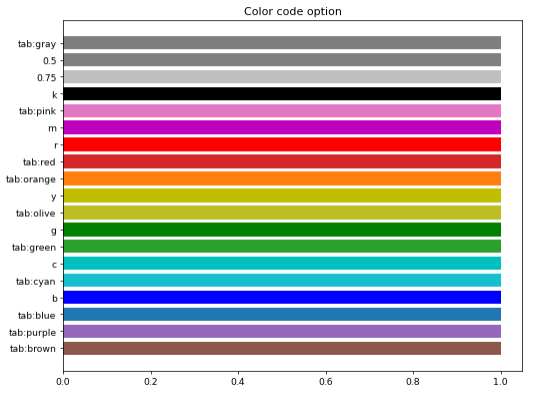

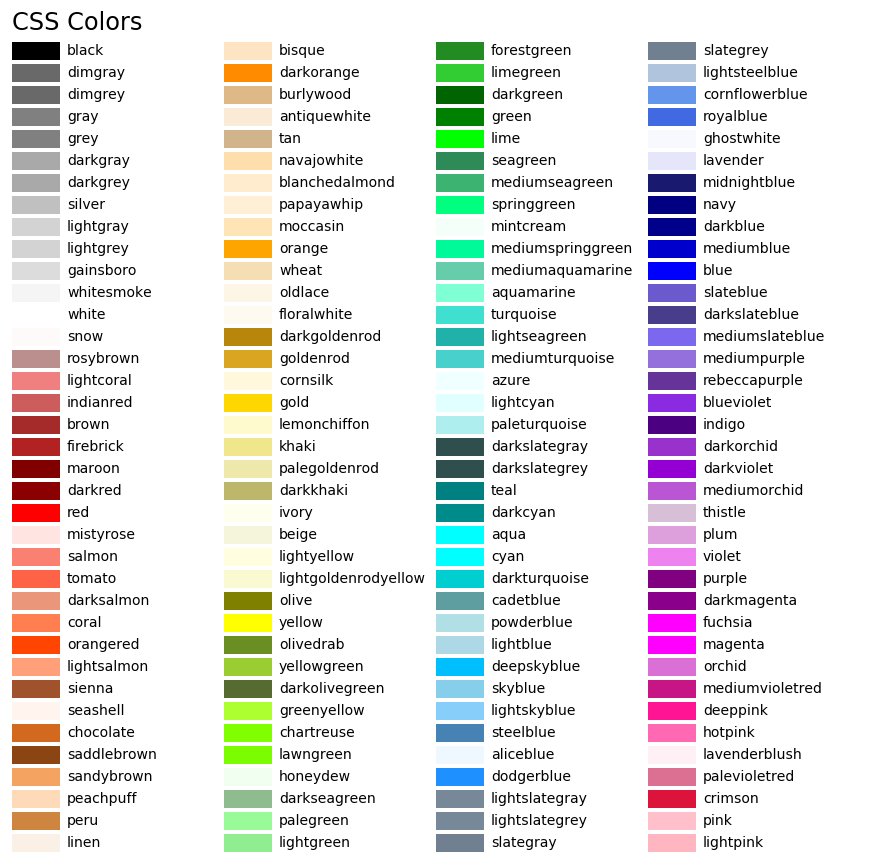

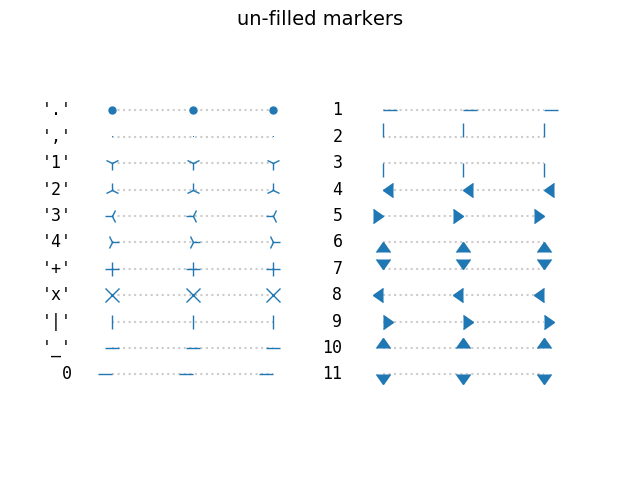

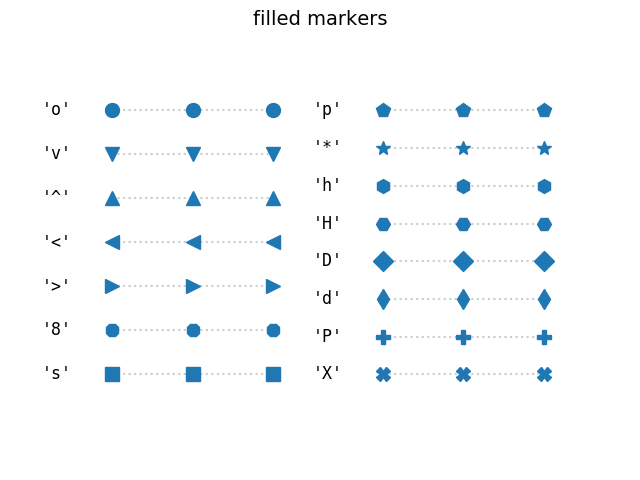

In [3]:
print("How Many Groups?")
num= input()
Total_Number_groups= int(num)+1
print("")

group_number_ID= []
for groupN in range (1,Total_Number_groups):
    group_number_ID.append(groupN)
print("Number of groups set=", len(group_number_ID), group_number_ID)
print("")

print("What is the GroupID number for each treatment category? (note: must match analysis file)")
GroupID_set=[]
for ID in range (1, Total_Number_groups):
    output_ID=input(ID)
    GroupID_set.append(output_ID)
print ("Group ID set=", GroupID_set)
print("")

print("What is Treatment Label for each Group ID? (Note: must exactly match text on analysis file)")
TrLabel_set=[]
for Label in range (1, Total_Number_groups):
    output_label=input(Label)
    TrLabel_set.append(output_label)
print("Treatment Labels set=", TrLabel_set)
print("")

print("What color do you want each group/treatment to be coded? Input text code listed in reference figure")
#todo: CHANGE so that the number index for input matches the labels listed, for easier reference 
color_code= []
for color in range (1, Total_Number_groups):
    output_color = input(color)
    color_code.append(output_color)
print("Color code set=", color_code)

print("What style of marker do you want for the scatter plots?")
marker_style= input()
print("Maker style set:", marker_style)

How Many Groups?


 7



Number of groups set= 7 [1, 2, 3, 4, 5, 6, 7]

What is the GroupID number for each treatment category? (note: must match analysis file)


1 1
2 2
3 3
4 4
5 5
6 6
7 7


Group ID set= ['1', '2', '3', '4', '5', '6', '7']

What is Treatment Label for each Group ID? (Note: must exactly match text on analysis file)


1 1d sal
2 5d sal
3 15d sal
4 1d 2et
5 5d 2et
6 15d 2et
7 1d 4et


Treatment Labels set= ['1d sal', '5d sal', '15d sal', '1d 2et', '5d 2et', '15d 2et', '1d 4et']

What color do you want each group/treatment to be coded? Input text code listed in reference figure


1 m
2 c
3 r
4 y
5 g
6 b
7 k


Color code set= ['m', 'c', 'r', 'y', 'g', 'b', 'k']
What style of marker do you want for the scatter plots?


 o


Maker style set: o


### Create reference tables of parameters set during setup- rerun setup steps if anything is inaccurate

Legend treatment colorcode
+----------+-----------------+------------+
| Group ID | Treatment Label | color code |
+----------+-----------------+------------+
|    1     |      1d sal     |     m      |
|    2     |      5d sal     |     c      |
|    3     |     15d sal     |     r      |
|    4     |      1d 2et     |     y      |
|    5     |      5d 2et     |     g      |
|    6     |     15d 2et     |     b      |
|    7     |      1d 4et     |     k      |
+----------+-----------------+------------+

Location of saved file: C:/Users/Mullo/Documents/output/Figures


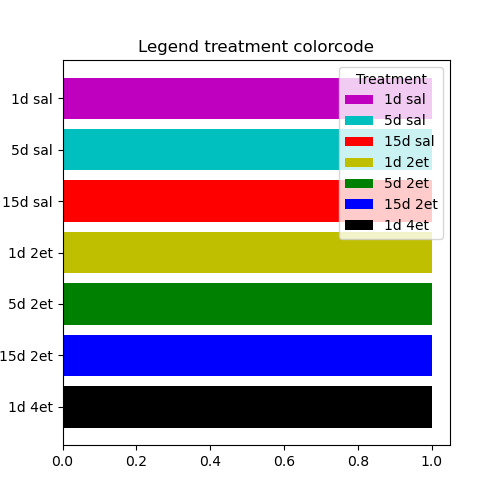

In [4]:
#Create table summarize 
FigureTitle="Legend treatment colorcode"
FigureDetail= 'Legend treatment colorcode'
TableTitle= 'Legend treatment colorcode'
print(TableTitle)
Table_colorcode= PrettyTable(['Group ID', 'Treatment Label', 'color code'])
for more in range (0,Total_Number_groups-1):
    Table_colorcode.add_row([GroupID_set[more], TrLabel_set[more], color_code[more]])
print(Table_colorcode)

#Create a dataframe to store these reference values 
setup_RefGroup= pd.DataFrame({"Group ID":GroupID_set, "Treatment Label":TrLabel_set, "Color Code":color_code})
print("")

#Creating a simple bar graph to visualize each treatment group
fig_legend, ax_rl = plt.subplots(figsize=(5,5))
bar_labels = TrLabel_set
bar_colors = color_code
bar_ref=ax_rl.barh(GroupID_set, 1, label=bar_labels, color=bar_colors, align='center')
y_length= []
for grow in range (0, len(GroupID_set)):
    y_length.append(1)
#ref_scatter= ax_rl.scatter(y_length, GroupID_set, label=bar_labels, color=bar_colors, marker= marker_style)
ax_rl.set_title(FigureTitle)
ax_rl.set_yticks(GroupID_set, labels= bar_labels)
ax_rl.invert_yaxis()
#legend= ax_rl.legend(title='Treatment', bbox_to_anchor=(1, 1), bbox_transform=fig_legend.transFigure)
ax_rl.legend(loc='upper right', title='Treatment', bbox_transform=fig_legend.transFigure)
plt.figure(fig_legend)

save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


**_________________________________________________________________________________________________________________________**

# Part 1: Generate representative brain (from kmeans notebook)
* This portion is an abbreviated version of the full "generating representative brain" notebook, and only inlcudes the portion that is needed for the analysis in part 2. 
* This part does not inlcude any visuals, except those necessary for quality check 

In [5]:
df2 = pd.read_csv(my_path + raw_data+ my_analysis_file) #Import files to pandas dataframe from local computer path
print("File input:", my_analysis_file)

#create a column with a datapoint ID so all future analysis points are joined to the right datapoint 
datapoint_ID=[]
for boom in range (0, len(df2)):
    input_asnum= int(boom)
    datapoint_ID.append(input_asnum)
df2["datapoint ID"]= datapoint_ID
print(df2)

dataset_xyz = df2[['ap','dv','ml']].values #Create 3D matrix for analysis #, 'datapoint ID']

File input: /f_chat_all_python.csv
     animal treatment    ap    dv    ml  groups  datapoint ID
0       F10   15d 2et -5.08  4.29 -1.11       6             0
1       F10   15d 2et -5.08  4.33 -1.11       6             1
2       F10   15d 2et -5.07  4.35 -1.07       6             2
3       F10   15d 2et -5.07  4.44 -1.06       6             3
4       F10   15d 2et -5.07  4.35 -1.05       6             4
...     ...       ...   ...   ...   ...     ...           ...
5037     F5    5d sal -4.35  4.12  2.03       2          5037
5038     F5    5d sal -4.35  4.12  2.06       2          5038
5039     F5    5d sal -4.35  4.27  2.06       2          5039
5040     F5    5d sal -4.35  4.29  2.06       2          5040
5041     F5    5d sal -4.35  4.28  2.14       2          5041

[5042 rows x 7 columns]


#### Determining number of clusters from average number of cells and running Kmeans clustering analysis 

In [6]:
cell_number = df2.groupby(['animal'])['groups'].count() 
cell_number_listed = cell_number.tolist()
animal_listed = df2['animal'].unique()
print("Summary of cell number for each animal:") 

#Summary Table 
summary_cellnumber = PrettyTable (['Animal', 'Number of counted cells'])

for j in range (0, len(animal_listed)):
    summary_cellnumber.add_row([animal_listed[j], cell_number_listed[j]])
    
print(summary_cellnumber)

#make table of mean and stdev of cell counts
summary_meanCellnum = PrettyTable(['Mean cell number per animal', 'stdev'])
summary_meanCellnum.add_row([cell_number.mean(), cell_number.std()])
print(summary_meanCellnum)

#Manually input number of clusters based on the updated average 
cluster_number= round(cell_number.mean())

#Input cluster number into the model and generate a k-means clustering model from the XYZ coordiantes
km_model = KMeans(n_clusters = cluster_number, init = "k-means++", max_iter = 300, n_init = 20, random_state = 0)
y_clusters = km_model.fit(dataset_xyz)
model_clusters = y_clusters.fit_predict(dataset_xyz)

#make table of kmeans model input values
print("Table: Input variables for k-means clustering model")
table_kmeans = PrettyTable(['Number of Clusters generated', 'Number of datapoints analyzed', 'Number of model iterations'])
table_kmeans.add_row([cluster_number, len(model_clusters), km_model.n_iter_])
print(table_kmeans)


Summary of cell number for each animal:
+--------+-------------------------+
| Animal | Number of counted cells |
+--------+-------------------------+
|  F10   |           1230          |
|  F11   |           424           |
|  F2.2  |           792           |
|  F2.3  |           620           |
|   F1   |           518           |
|  F2.1  |           438           |
|   F5   |           1020          |
+--------+-------------------------+
+-----------------------------+--------------------+
| Mean cell number per animal |       stdev        |
+-----------------------------+--------------------+
|      720.2857142857143      | 309.09206518755013 |
+-----------------------------+--------------------+
Table: Input variables for k-means clustering model
+------------------------------+-------------------------------+----------------------------+
| Number of Clusters generated | Number of datapoints analyzed | Number of model iterations |
+------------------------------+----------------

#### Create dataset with cluster ID 

In [7]:
#Add cluster ID to the main dataset
print("Updated Dataset with Cluster Information from", my_analysis_file)
data_cluster= pd.DataFrame( {'section_ap':dataset_xyz[:,0], 'dv':dataset_xyz[:,1], 'ml':dataset_xyz[:,2], 'km_cluster_id':km_model.labels_}) #{'point ID':dataset_xyz[:, 3],
data_clustersort= data_cluster.sort_values(by='km_cluster_id')

Updated Dataset with Cluster Information from /f_chat_all_python.csv


#### Generate coordinates of cluser centroids for analysis  

In [8]:
#Import information on cluster centroids 
centroids = km_model.cluster_centers_

#create list of all cluster IDs
km_sortclusterID = data_cluster.sort_values(by=['km_cluster_id'])
k_model_clusterID= km_sortclusterID['km_cluster_id'].unique().tolist()
print("Total number of clusters=", len(k_model_clusterID))

#create centroid dataset for future analysis 
km_cent=pd.DataFrame({'cluster ID':k_model_clusterID, 'ap':centroids[:,0], 'dv':centroids[:,1], 'ml':centroids[:,2]})
km_cent.index=km_cent['cluster ID']
print(km_cent)



#_______[update- add cluster ID coordinates to dataframe with POI cluster ID for easier graphing]________________________________________________________

#print(data_clustersort)
##print(data_clustersort['point ID'][0])
#print(data_clustersort['km_cluster_id'][0])
#Create a summary dataframe that includes the centroid coordinates with the cluster ID created by the model 
#pointID_clap=[]
#pointID_cldv=[]
#pointID_clml=[]
#pointID_centID=[]
#for splish in range (0, len(data_clustersort)):
    #input_datapoint= data_clustersort['point ID'][splish]
    #input_clusterID= data_clustersort['km_cluster_id'][splish]
    #for splash in range (0, len(km_cent)):
        #centroid_id= km_cent['cluster ID'][splash]
        #ap_center= km_cent['ap'][splash]
        #dv_center= km_cent['dv'][splash]
        #ml_center=km_cent['ml'][splash]
        #if input_clusterID == centroid_id:
            #pointID_centID.append(centroid_id)
            #pointID_clap.append(ap_center)
            #pointID_cldv.append(dv_center)
            #pointID_clml.append(ml_center)
        #else:
            #pass
#print(data_clustersort['km_cluster_id'], point_ID_centID)

Total number of clusters= 720
            cluster ID        ap        dv        ml
cluster ID                                          
0                    0 -4.697143  3.674286  0.547143
1                    1 -4.747500  4.162500 -0.920000
2                    2 -4.343077  4.144615  1.301538
3                    3 -4.620000  4.115833 -1.427500
4                    4 -4.764000  4.399000  0.872000
...                ...       ...       ...       ...
715                715 -4.140000  4.090000 -1.470000
716                716 -4.860000  4.670000  0.620000
717                717 -4.740000  4.250000 -1.530000
718                718 -4.212000  4.466000 -0.994000
719                719 -4.560000  4.620000 -0.640000

[720 rows x 4 columns]


***-----------------------------------------------------------------------------------------------------------------------***

# Part 2: Visualize location of labelled points of interest (POI) across brain region 
Ex: Use cluster ID to recognize location and grouping of activated neurons (Fos+) by treatment group (etoh injection dose or timepoint)

### Load the new analysis file of the labelled cells of interest [ **points of interest (POI)**] from a csv file <br>

In [9]:
#Import files to pandas dataframe from local computer path
data_POI= pd.read_csv(my_path + raw_data + my_analysis_file_POI)
#data_POI= pd.read_csv(my_path + raw_data + '/f_rVTA_python.csv')

#confirm that the excel sheet is correctly imported, the first few rows of the .csv file will be shown
print("File input:", my_analysis_file_POI)
data_POI.head(5)


File input: /f_chatfos_ByTreatment.csv


,animal,treatment,ap,dv,ml,groups
0,F2.2,1d 2et,-4.71,4.29,-1.13,4
1,F2.2,1d 2et,-4.71,4.12,-0.97,4
2,F2.2,1d 2et,-4.71,4.05,-0.93,4
3,F2.2,1d 2et,-4.71,4.00,-0.83,4
4,F2.2,1d 2et,-4.71,3.79,-0.77,4


## Visualize: all POI datapoints in the 3D space by treatment group

**TO DO** fix figure legend to be treatment names and colors

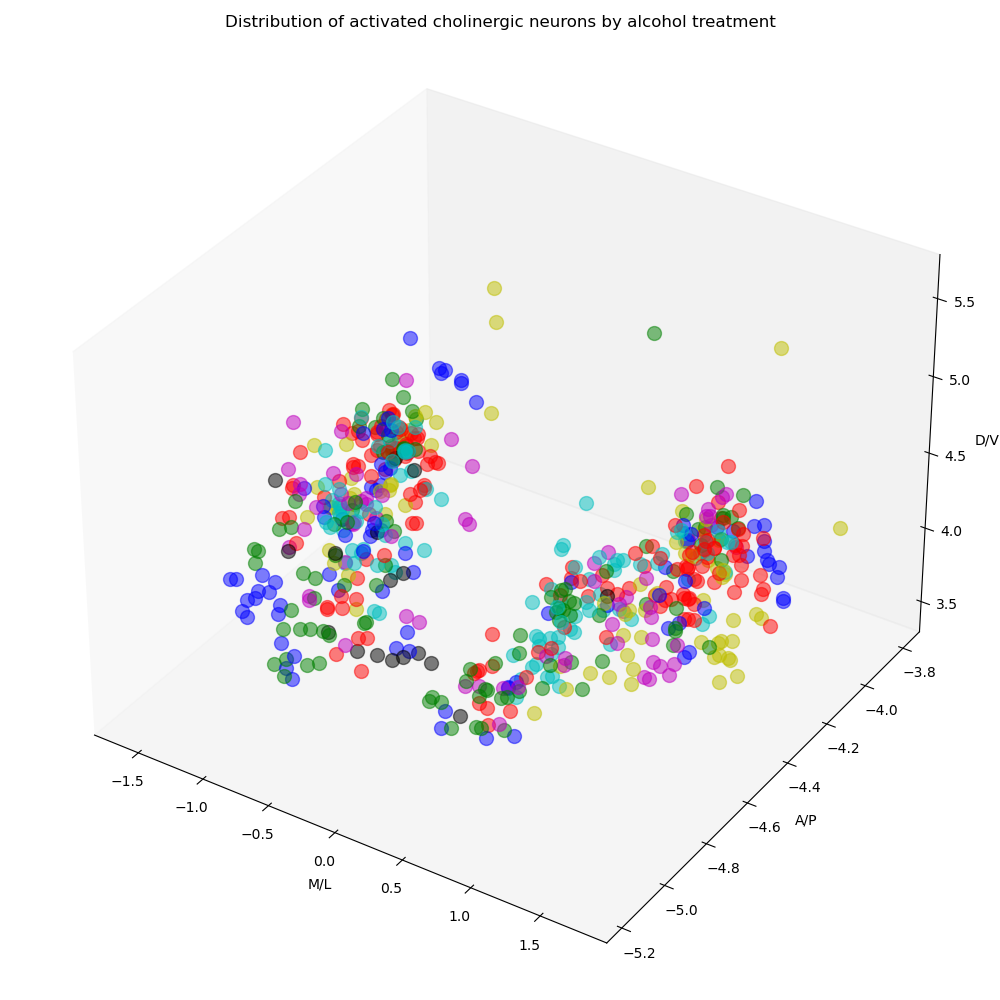

Figure saved: Distribution of activated cholinergic neurons by alcohol treatment
Saved File Timestamp: (2023-12-04)
Location of saved file: C:/Users/Mullo/Documents/output/Figures


In [10]:
FigureTitle = "Distribution of activated cholinergic neurons by alcohol treatment"
FigureDetail= '3D all POI in treat color'
#Generate the 3D plot outline and plot size

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig_TreatColor = plt.figure()
ax_tc = fig_TreatColor.add_subplot(projection="3d")

#Define each axis value and plot based on groups
x_tc = data_POI["ml"].tolist() 
y_tc = data_POI["ap"].tolist() 
z_tc = data_POI["dv"].tolist() 
#set figure axis to correct variable name 
ax_tc.set_xlabel('M/L')
ax_tc.set_ylabel('A/P')
ax_tc.set_zlabel('D/V')
plt.title(FigureTitle)

#Define the variable to plot the color bar grid 
#print(setup_RefGroup)
color_bar_Title='Treatment group (saline - etoh)'
color_bar= data_POI['groups'].tolist()
colorcode_gID= setup_RefGroup['Group ID'].unique().astype('str')
colorcode_Treat= setup_RefGroup['Treatment Label'].unique().astype('str')
colorcode_color = setup_RefGroup['Color Code'].tolist()
        
for gr in range (0, len(color_bar)):
    group_ref2= color_bar[gr]
    x_ref= data_POI["ml"][gr]
    y_ref= data_POI["ap"][gr] 
    z_ref= data_POI["dv"][gr] 
    for ref2 in range (0, len(colorcode_gID)):
        input_group2= int(colorcode_gID[ref2])
        input_color2= colorcode_color[ref2]
        input_label2= colorcode_Treat[ref2]
        if group_ref2== input_group2:
            ax_tc.scatter(x_ref, y_ref, z_ref, marker=marker_style, s=100, c= input_color2, label=input_label2, alpha=0.5)
        else:
            pass
#FIgure out how to fix legend later


#making background transparent 
# make the panes transparent
#ax_tc.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax_tc.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax_tc.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax_tc.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_tc.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_tc.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax_tc.view_init(elev=34, azim=-57, roll=0)
plt.show()

#________________________________________________________________
#Save Figure File to path folder
print("Figure saved:", FigureTitle)
print("Saved File Timestamp:", file_date_name)

save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)


#_____________[edits needed]____________
#adjust cluster sizes/ dot sizes 

## Visualize: Crossection 2D of all POI datapoints by treatment

#### set all variables used for 2D cross section figures

In [11]:
#Set parameters for ALL 2D cross section figures

#Define anterior-posterior range and splitting (POI)
ap_POIlisted= data_POI.sort_values(by=['ap'])['ap'].unique()
ap_POImin= min(ap_POIlisted)
ap_POImax= max (ap_POIlisted)
ap_POIrange= abs(ap_POImax-ap_POImin)
#axis based on POI dataset
ml_POI= data_POI["ml"].tolist()
ap_POI= data_POI["ap"].tolist()
dv_POI= data_POI["dv"].tolist()
min_POIx= round(min(ml_POI))
max_POIx= round(max(ml_POI))
min_POIy= round(min(dv_POI))
max_POIy= round(max(dv_POI))

#Define anterior-posterior range and splitting (rep brain)
ap_kmlisted= km_cent.sort_values(by=['ap'])['ap'].unique()
ap_kmmin= min(ap_kmlisted)
ap_kmmax= max (ap_kmlisted)
ap_kmrange= abs(ap_kmmax-ap_kmmin)
#axis based on rep brain model 
km_ml= km_cent['ml'].tolist()
km_ap= km_cent['ap'].tolist()
km_dv= km_cent['dv'].tolist()
min_kmx= round(min(km_ml))
max_kmx= round(max(km_ml))
min_kmy= (min(km_dv))
max_kmy= (max(km_dv))

#min and max of all values 
mina_ml= min(ml_POI + km_ml)
maxa_ml= round(max(ml_POI + km_ml))
mina_dv=min((dv_POI) + (km_dv))
maxa_dv=round(max(dv_POI + km_dv))
mina_ap=min(ap_POI + km_ap)
maxa_ap=round(max(ap_POI + km_ap))

#define color of markers
color_bar= data_POI['groups'].tolist()
colorcode_gID= setup_RefGroup['Group ID'].unique().astype('str')
colorcode_Treat= setup_RefGroup['Treatment Label'].unique().astype('str')
colorcode_color = setup_RefGroup['Color Code'].tolist()


#cross section option 1: based on distance between cross sections
cross_step= 0.2 #space between cross sections
count_num_section= round( (ap_kmrange) / cross_step) #use if you want to base number of cross section images by a set distance

#cross section option 2: based on number of cross sections to be used 
number_subplots=4 #number of cross section subplots wanted
find_step= (ap_kmrange)/(number_subplots) #Determine the distiance between cross sections based on number of subplots wanted

ap_all_cross= [] #create the defined cross section list 
for letsgo in range (0, number_subplots+1):
    ap_value= ap_kmmin + (letsgo*find_step)
    ap_all_cross.append(ap_value)

#cross section option 3: determine the a-p range desired for all cross sections 
ap_all_cross_manual=[]
#NOTE: only using option 2 and 3 with list current code

#Create subplot and subplot reference variables 
sct_ref= []
for expand in range (0, number_subplots+1):
    sct_ref.append(expand)
#Setup the section varaible names 
sct_minap= []
sct_maxap= []
for identify in range (0, len(sct_ref)-1):
    min_ref= round(ap_all_cross[identify], 2)
    sct_minap.append(min_ref)
for shout in range (1, len(sct_ref)):
    max_ref= round(ap_all_cross[shout], 2)
    sct_maxap.append(max_ref)

#create reference to cross sections
sct1= [sct_minap[0], sct_maxap[0]]
sct2= [sct_minap[1], sct_maxap[1]]
sct3= [sct_minap[2], sct_maxap[2]]
sct4=[sct_minap[3], sct_maxap[3]]

TableTitle= 'Table: Cross section ap coordinates (chon atlas)'
print(TableTitle)
table_xsection= PrettyTable(['cross section #', 'posterior ap', 'anterior ap'])
table_xsection.add_row(['1', sct1[0], sct1[1]])
table_xsection.add_row(['2', sct2[0], sct2[1]])
table_xsection.add_row(['3', sct3[0], sct3[1]])
table_xsection.add_row(['4', sct4[0], sct4[1]])
print(table_xsection)

#______________________________________________
#updates: sections to be manually entred as an option instead of evenly distributed
#maybe add an input option for this stage as well to help with customization

Table: Cross section ap coordinates (chon atlas)
+-----------------+--------------+-------------+
| cross section # | posterior ap | anterior ap |
+-----------------+--------------+-------------+
|        1        |     -5.4     |     -5.0    |
|        2        |     -5.0     |    -4.61    |
|        3        |    -4.61     |    -4.21    |
|        4        |    -4.21     |    -3.81    |
+-----------------+--------------+-------------+


### All POI: Create cross section figure

Location of saved file: C:/Users/Mullo/Documents/output/Figures
file saved Distribution of fos-activated cholinergic neurons across treatment


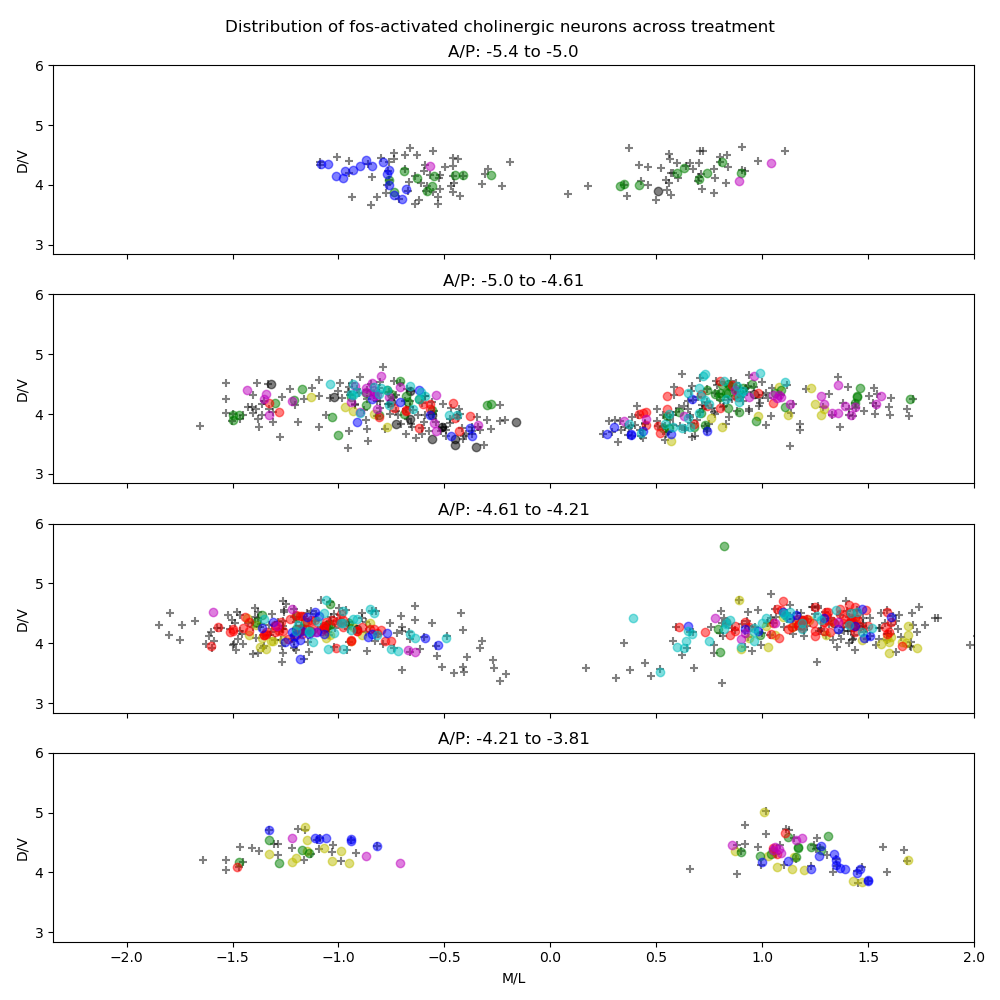

In [12]:
#create figure- specifics
FigureTitle= 'Distribution of fos-activated cholinergic neurons across treatment'
FigureDetail= 'cross section of all POI by treatment'
fig_2D_allPOI, ax_2DPOI= plt.subplots(4,1, sharey='all', sharex='col')
fig_2D_allPOI.suptitle(FigureTitle)

#Create the refernece sections to be added in cross section 
#NOTE: will need to be manually update if want more than 4 crossesctions
#TODO: update this variable to be auto generated based on experimenter input on number of cross sections 

sct1A=ax_2DPOI[0]
sct1A.set_xlim(mina_ml-0.5, maxa_ml)
sct1A.set_ylim(mina_dv-0.5, maxa_dv)
sct1A.set_ylabel('D/V')
sct1A.set_title(f"A/P: {sct1[0]} to {sct1[1]}")
sct2A= ax_2DPOI[1]
sct2A.set_title(f"A/P: {sct2[0]} to {sct2[1]}")
sct2A.set_ylabel('D/V')
sct3A= ax_2DPOI[2]
sct3A.set_ylabel('D/V')
sct3A.set_title(f"A/P: {sct3[0]} to {sct3[1]}")
sct4A= ax_2DPOI[3]
sct4A.set_title(f"A/P: {sct4[0]} to {sct4[1]}")
sct4A.set_ylabel('D/V')
sct4A.set_xlabel('M/L')

#Input dataset to plot 

#FIRST: plot location of representative brain centroids for refernece 
color_input_2='k'
alpha_input_2= 0.5
marker_input_2='+'
for tehee in range (0, len(km_cent)):
    plot_ref_section= km_ap[tehee]
    x_ml= km_ml[tehee]
    y_dv= km_dv[tehee]
    for yaha in range (0, len(ap_kmlisted)):
        ref_section= ap_kmlisted[yaha]
        if plot_ref_section == ref_section:
            if (plot_ref_section>= sct1[0]) and (plot_ref_section<= sct1[1]):
                sct1A.scatter(x_ml, y_dv, c=color_input_2, alpha= alpha_input_2, marker=marker_input_2)
            elif (plot_ref_section>= sct2[0]) and (plot_ref_section<= sct2[1]):
                sct2A.scatter(x_ml, y_dv, c=color_input_2, alpha= alpha_input_2, marker=marker_input_2)
            elif (plot_ref_section>= sct3[0]) and (plot_ref_section<= sct3[1]):
                sct3A.scatter(x_ml, y_dv, c=color_input_2, alpha= alpha_input_2, marker=marker_input_2)
            elif (plot_ref_section>= sct4[0]) and (plot_ref_section<= sct4[1]):
                sct4A.scatter(x_ml, y_dv, c=color_input_2, alpha= alpha_input_2, marker=marker_input_2)
        else:
            pass

#NEXT: create variables for POI graphing
colorcode_forplot=[]
trlabel_forplot=[]
for splish in range (0, len(color_bar)):
    gr_forcolorref= color_bar[splish]
    for splash in range (0, len(colorcode_gID)):
        input_group= int(colorcode_gID[splash])
        input_color= colorcode_color[splash]
        input_label= colorcode_Treat[splash]
        if gr_forcolorref == input_group:
            colorcode_forplot.append(input_color)
            trlabel_forplot.append(input_label)
        else:
            pass

alpha_input_3= 0.5
marker_input_3= marker_style       
for wohelo in range (0, len(ap_POI)):
    plot_ref_section= ap_POI[wohelo]
    x_ml= ml_POI[wohelo]
    y_dv= dv_POI[wohelo]
    color_forplot= colorcode_forplot[wohelo]
    for foray in range (0, len(ap_POIlisted)):
        ref_section= ap_POIlisted[foray]
        if plot_ref_section == ref_section:
            if (plot_ref_section>= sct1[0]) and (plot_ref_section<= sct1[1]):
                sct1A.scatter(x_ml, y_dv, c=color_forplot, alpha= alpha_input_3, marker=marker_input_3)
            elif (plot_ref_section>= sct2[0]) and (plot_ref_section<= sct2[1]):
                sct2A.scatter(x_ml, y_dv, c=color_forplot, alpha= alpha_input_3, marker=marker_input_3)
            elif (plot_ref_section>= sct3[0]) and (plot_ref_section<= sct3[1]):
                sct3A.scatter(x_ml, y_dv, c=color_forplot, alpha= alpha_input_3, marker=marker_input_3)
            elif (plot_ref_section>= sct4[0]) and (plot_ref_section<= sct4[1]):
                sct4A.scatter(x_ml, y_dv, c=color_forplot, alpha= alpha_input_3, marker=marker_input_3)
        else:
            pass        
#TODO: figure out legend
plt.figure(fig_2D_allPOI)

##_____________________________________________________________________________________
#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


### All POI: Create histogram of ml and dv spread by treatment for each cross section

#### calculate subplot cross section for each datapoint and update dataframes with section ID and L/R hemisphere side for easier future plotting

In [13]:
#Create dataframes to idenitfy which subplot each datapoint belongs, to help filtering for figure plotting 
#Two datasets to split- one for the representative brain, and one for the POI dataframe

#dataframe: rep bain 
subplot_kmsct=[]
for hip in range (0, len(km_cent)):
    ref_ap= round(km_ap[hip], 3)
    if (ref_ap>=sct1[0]) and (ref_ap<= sct1[1]):
        subplot_kmsct.append(1)
    elif (ref_ap>= sct2[0]) and (ref_ap<= sct2[1]):
        subplot_kmsct.append(2)
    elif (ref_ap>= sct3[0]) and (ref_ap<= sct3[1]):
        subplot_kmsct.append(3)
    elif (ref_ap>= sct4[0]) and (ref_ap<= sct4[1]):
        subplot_kmsct.append(4)
    else:
        subplot_kmsct.append(0)
km_cent['xsct ID']= subplot_kmsct


#repeat for L or R hemisphere values 
subplot_kmhemi=[]
for frog in range (0, len(km_cent)):
    ref_ml= km_ml[frog]
    if ref_ml >= 0:
        subplot_kmhemi.append('R')
    elif ref_ml <=0:
        subplot_kmhemi.append('L')
    else:
        subplot_kmhemi.append('x')
km_cent['hemisphere']=subplot_kmhemi
print("updated dataframe: neuronal space of representative brain")
print(km_cent)
print("")
#Put in code to save this dataframe as csv file 
        
#datafram: POI
subplot_POIsct=[]
for hop in range (0, len(data_POI)):
    ref_ap2= round(data_POI['ap'][hop], 3)
    if (ref_ap2>=sct1[0]-1) and (ref_ap2<= sct1[1]):
        subplot_POIsct.append(1)
    elif (ref_ap2>= sct2[0]) and (ref_ap2<= sct2[1]):
        subplot_POIsct.append(2)
    elif (ref_ap2>= sct3[0]) and (ref_ap2 <= sct3[1]):
        subplot_POIsct.append(3)
    elif (ref_ap2>= sct4[0]) and (ref_ap2<= sct4[1]):
        subplot_POIsct.append(4)
    else:
        subplot_POIsct.append(0)
data_POI['xsct ID']= subplot_POIsct

subplot_POIhemi=[]
for pig in range (0, len(data_POI)):
    ref_ml= ml_POI[pig]
    if ref_ml >= 0:
        subplot_POIhemi.append('R')
    elif ref_ml <=0:
        subplot_POIhemi.append('L')
    else:
        subplot_POIhemi.append('x')
data_POI['hemisphere']=subplot_POIhemi
print("updated dataframe: all POI datapoints by treatment")
print(data_POI)
#save dtaframe as csv file


updated dataframe: neuronal space of representative brain
            cluster ID        ap        dv        ml  xsct ID hemisphere
cluster ID                                                              
0                    0 -4.697143  3.674286  0.547143        2          R
1                    1 -4.747500  4.162500 -0.920000        2          L
2                    2 -4.343077  4.144615  1.301538        3          R
3                    3 -4.620000  4.115833 -1.427500        2          L
4                    4 -4.764000  4.399000  0.872000        2          R
...                ...       ...       ...       ...      ...        ...
715                715 -4.140000  4.090000 -1.470000        4          L
716                716 -4.860000  4.670000  0.620000        2          R
717                717 -4.740000  4.250000 -1.530000        2          L
718                718 -4.212000  4.466000 -0.994000        3          L
719                719 -4.560000  4.620000 -0.640000        3     

### split dataframe information between cross section and hemisphere for easier plotting

In [14]:
#Filter all datasets out by different sections for histograms

km_sct1= km_cent.groupby('xsct ID').get_group(1)
km_sct1L= km_sct1.groupby('hemisphere').get_group('L')
km_sct1R= km_sct1.groupby('hemisphere').get_group('R')

km_sct2= km_cent.groupby('xsct ID').get_group(2)
km_sct2L= km_sct2.groupby('hemisphere').get_group('L')
km_sct2R= km_sct2.groupby('hemisphere').get_group('R')

km_sct3= km_cent.groupby('xsct ID').get_group(3)
km_sct3L= km_sct3.groupby('hemisphere').get_group('L')
km_sct3R= km_sct3.groupby('hemisphere').get_group('R')

km_sct4= km_cent.groupby('xsct ID').get_group(4)
km_sct4L= km_sct4.groupby('hemisphere').get_group('L')
km_sct4R= km_sct4.groupby('hemisphere').get_group('R')

POI_sct1= data_POI.groupby('xsct ID').get_group(1)
POI_sct1L= POI_sct1.groupby('hemisphere').get_group('L')
POI_sct1R= POI_sct1.groupby('hemisphere').get_group('R')
grlist_P1L=POI_sct1L.groupby('groups')['groups'].unique()
grlist_P1R=POI_sct1R.groupby('groups')['groups'].unique()

POI_sct2= data_POI.groupby('xsct ID').get_group(2)
POI_sct2L= POI_sct2.groupby('hemisphere').get_group('L')
POI_sct2R= POI_sct2.groupby('hemisphere').get_group('R')
grlist_P2L=POI_sct2L.groupby('groups')['groups'].unique()
grlist_P2R=POI_sct2R.groupby('groups')['groups'].unique()

POI_sct3= data_POI.groupby('xsct ID').get_group(3)
POI_sct3L= POI_sct3.groupby('hemisphere').get_group('L')
POI_sct3R= POI_sct3.groupby('hemisphere').get_group('R')
grlist_P3L=POI_sct3L.groupby('groups')['groups'].unique()
grlist_P3R=POI_sct3R.groupby('groups')['groups'].unique()

POI_sct4= data_POI.groupby('xsct ID').get_group(4)
POI_sct4L= POI_sct4.groupby('hemisphere').get_group('L')
POI_sct4R= POI_sct4.groupby('hemisphere').get_group('R')
grlist_P4L=POI_sct4L.groupby('groups')['groups'].unique()
grlist_P4R=POI_sct4R.groupby('groups')['groups'].unique()

print("step complete!")

step complete!


### All POI: Ap distributiom 

In [ ]:
#create figure- specifics
FigureTitle= 'Ap Distribution of activated cholinergic neurons across treatment'
FigureDetail=' scatter of ap distributiiom '
fig_2Dap, ax_ap= plt.subplots()
fig_2Dap.suptitle(FigureTitle)
#Create plot axis details 
ax_ap.set_xlim (ap_kmmin-0.25, ap_kmmax+0.25)
ax_ap.set_xlabel('A/P')
ax_ap.set_ylim(min_kmy, max_kmy)
ax_ap.set_ylabel('D/V')

#pull out only left values - make variables for plot
color_input_km='0.5'
alpha_input_km= 1
marker_input_km='+'
for spring in range (0, len(km_cent)):
    ml_check= km_cent['ml'][spring]
    if ml_check <= 0:
        ml_value= km_cent['ml'][spring] 
        ap_value= km_cent['ap'][spring]
        dv_value= km_cent['dv'][spring]
        ax_ap.scatter(ap_value, dv_value, c=color_input_km, alpha= alpha_input_km, marker=marker_input_km)
    else:
        pass

#Plot for only left hemisphere
alpha_forplot= 0.5
for summer in range (0, len(ap_POI)):
    ml_check= ml_POI[summer]
    ap_value= ap_POI[summer]
    dv_value= dv_POI[summer]
    treat_value= data_POI['treatment'][summer]
    color_forplot= colorcode_forplot[summer]
    ax_ap.scatter(ap_value, dv_value, c=color_forplot, alpha= alpha_forplot, marker=marker_style)
    
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)

#######################################################################################################################################################################   
#Make a histogram instead 
FigureTitle= 'histogram ap distribution of activated cholinergic neurons across treatment'
FigureDetail= 'histogram of POI ap range'
fig_histap, ax_histap= plt.subplots()
fig_histap.suptitle(FigureTitle)
#Create plot axis details 
ax_histap.set_xlim (ap_kmmin-0.25, ap_kmmax+0.25)
ax_histap.set_xlabel('A/P')
#ax_histap.set_ylim(min_kmy, max_kmy)
ax_histap.set_ylabel('number of neurons')

#make a histogram 
bar_pattern='///'
#create a color code based on specific group numbers, and variables for graphing based on group numbers 
input_forloop= data_POI['groups'].unique()
input_dataforanalysis= data_POI
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            ax_histap.hist(dataset_forplot['ap'], color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)



Location of saved file: C:/Users/Mullo/Documents/output/Figures
file saved Ap Distribution of activated cholinergic neurons across treatment


### All POI: Create figure histogram for treatment distribution along ml and dv axis for all cross-sections
*NOTE* this section is currently hard-coded for a subplot 4 cross sections
- needs to be updated with an iterable for-loop at a later date to allow for more versitility

In [ ]:
#Makea  histogram of each cross section subplot
#All section variables:
bin_number= 5
color_allhist= '0.75'
alpha_value= 0.5
bar_pattern= '///'

###############################################################################################################################
#create a histogram for each cross section- SECTION 1
FigureTitle= "POI histogram in cross section 1"
FigureDetail= 'POI histogram 1'
fig_hist1, ax_hist1= plt.subplots(4, sharey='all')
fig_hist1.suptitle(FigureTitle)
#First, generate each plot for one cross section 
topleft1=ax_hist1[0]
topleft1.set_xlim(min_kmx, 0)
topleft1.set_title("ML distribution, left")
topleft1.set_ylabel('number of neurons')
sideleft1=ax_hist1[1]
sideleft1.set_xlim(min_kmy, max_kmy)
sideleft1.set_title("DV distribution, left")
sideleft1.set_ylabel('number of neurons')
topright1= ax_hist1[2]
topright1.set_xlim(0, max_kmx)
topright1.set_title("ML distribution, right")
topright1.set_ylabel('number of neurons')
sideright1=ax_hist1[3]
sideright1.set_xlim(min_kmy, max_kmy)
sideright1.set_title("DV distribution, right")
sideright1.set_ylabel('number of neurons')

#Histogram of left hemisphere, cross section 1 
topleft1.hist(POI_sct1L['ml'],bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
sideleft1.hist(POI_sct1L['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
grlist_P1L=POI_sct1L.groupby('groups')['groups'].unique().tolist()

#create histogram based on group/treatment number and color
input_forloop= grlist_P1L
input_dataforanalysis= POI_sct1L
plot_mlonfigure= topleft1
plot_dvonfigure= sideleft1
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch= bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch= bar_pattern)
        else:
            pass

#Histogram: right hemisphere, cross section 1        
topright1.hist(POI_sct1R['ml'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
sideright1.hist(POI_sct1R['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
grlist_P1R=POI_sct1R.groupby('groups')['groups'].unique().tolist()
#create a color code based on specific group numbers, and variables for graphing based on group numbers 
input_forloop= grlist_P1R
input_dataforanalysis= POI_sct1R
plot_mlonfigure= topright1
plot_dvonfigure= sideright1
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

#Save Figure
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

######################################################################################################################################################

#histogram: cross section 2
FigureTitle= "POI histogram in cross section 2"
FigureDetail= 'POI histogram 2'

fig_hist2, ax_hist2= plt.subplots(4, sharey='all')
fig_hist2.suptitle(FigureTitle)
#define subplot axis and variables 
topleft2=ax_hist2[0]
topleft2.set_xlim(min_kmx, 0)
topleft2.set_title("ML distribution, left")
topleft2.set_ylabel('number of neurons')
sideleft2=ax_hist2[1]
sideleft2.set_xlim(min_kmy, max_kmy)
sideleft2.set_title("DV distribution, left")
sideleft2.set_ylabel('number of neurons')
topright2= ax_hist2[2]
topright2.set_xlim(0, max_kmx)
topright2.set_title("ML distribution, right")
topright2.set_ylabel('number of neurons')
sideright2=ax_hist2[3]
sideright2.set_xlim(min_kmy, max_kmy)
sideright2.set_title("DV distribution, right")
sideright2.set_ylabel('number of neurons')

#Histogram:left hemisphere 
topleft2.hist(POI_sct2L['ml'],bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
sideleft2.hist(POI_sct2L['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
grlist_P2L=POI_sct2L.groupby('groups')['groups'].unique().tolist()

#create histogram based on group/treatment number and color
input_forloop= grlist_P2L
input_dataforanalysis= POI_sct2L
plot_mlonfigure= topleft2
plot_dvonfigure= sideleft2
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

#Histogram: right hemisphere       
topright2.hist(POI_sct2R['ml'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
sideright2.hist(POI_sct2R['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
grlist_P2R=POI_sct2R.groupby('groups')['groups'].unique().tolist()
#create a color code based on specific group numbers, and variables for graphing based on group numbers 
input_forloop= grlist_P2R
input_dataforanalysis= POI_sct2R
plot_mlonfigure= topright2
plot_dvonfigure= sideright2
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass


plt.figure(fig_hist2)
#Save Figure 
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

##############################################################################################################################################################
#histogram: cross section 3
FigureTitle= "POI histogram in cross section 3"
FigureDetail= 'POI histogram 3'

fig_hist3, ax_hist3= plt.subplots(4, sharey='all')
fig_hist3.suptitle(FigureTitle)

#First, generate each plot for one cross section 
topleft3=ax_hist3[0]
topleft3.set_xlim(min_kmx, 0)
topleft3.set_title("ML distribution, left")
topleft3.set_ylabel('number of neurons')
sideleft3=ax_hist3[1]
sideleft3.set_xlim(min_kmy, max_kmy)
sideleft3.set_title("DV distribution, left")
sideleft3.set_ylabel('number of neurons')
topright3= ax_hist3[2]
topright3.set_xlim(0, max_kmx)
topright3.set_title("ML distribution, right")
topright3.set_ylabel('number of neurons')
sideright3=ax_hist3[3]
sideright3.set_xlim(min_kmy, max_kmy)
sideright3.set_title("DV distribution, right")
sideright3.set_ylabel('number of neurons')

#Histogram:left hemisphere 
topleft3.hist(POI_sct3L['ml'],bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
sideleft3.hist(POI_sct3L['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
grlist_P3L=POI_sct3L.groupby('groups')['groups'].unique().tolist()

#create histogram based on group/treatment number and color
input_forloop= grlist_P3L
input_dataforanalysis= POI_sct3L
plot_mlonfigure= topleft3
plot_dvonfigure= sideleft3
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

#Histogram: right hemisphere       
topright3.hist(POI_sct3R['ml'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
sideright3.hist(POI_sct3R['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
grlist_P3R=POI_sct3R.groupby('groups')['groups'].unique().tolist()
#create a color code based on specific group numbers, and variables for graphing based on group numbers 
input_forloop= grlist_P3R
input_dataforanalysis= POI_sct3R
plot_mlonfigure= topright3
plot_dvonfigure= sideright3
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

plt.figure(fig_hist3)
#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

#####################################################################################################################################################################
#histogram: for each group and for each region 
FigureTitle= "POI histogram in cross section 4"
FigureDetail= 'POI histogram 4'
fig_hist4, ax_hist4= plt.subplots(4, sharey='all')
fig_hist4.suptitle(FigureTitle)

#First, generate each plot for one cross section 
topleft4=ax_hist4[0]
topleft4.set_xlim(min_kmx, 0)
topleft4.set_title("ML distribution, left")
topleft4.set_ylabel('number of neurons')
sideleft4=ax_hist4[1]
sideleft4.set_xlim(min_kmy, max_kmy)
sideleft4.set_title("DV distribution, left")
sideleft4.set_ylabel('number of neurons')
topright4= ax_hist4[2]
topright4.set_xlim(0, max_kmx)
topright4.set_title("ML distribution, right")
topright4.set_ylabel('number of neurons')
sideright4=ax_hist4[3]
sideright4.set_xlim(min_kmy, max_kmy)
sideright4.set_title("DV distribution, right")
sideright4.set_ylabel('number of neurons')

#Histogram:left hemisphere 
topleft4.hist(POI_sct4L['ml'],bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
sideleft4.hist(POI_sct4L['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
grlist_P4L=POI_sct4L.groupby('groups')['groups'].unique().tolist()

#create histogram based on group/treatment number and color
input_forloop= grlist_P4L
input_dataforanalysis= POI_sct4L
plot_mlonfigure= topleft4
plot_dvonfigure= sideleft4
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

#Histogram: right hemisphere       
topright4.hist(POI_sct4R['ml'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
sideright4.hist(POI_sct4R['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
grlist_P4R=POI_sct4R.groupby('groups')['groups'].unique().tolist()
#create a color code based on specific group numbers, and variables for graphing based on group numbers 
input_forloop= grlist_P4R
input_dataforanalysis= POI_sct4R
plot_mlonfigure= topright4
plot_dvonfigure= sideright4
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass
plt.figure(fig_hist4)

#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)


### All POI: Visual 2: boxplox to show distribtuion of data across treatments
- for each cross section: vertical violin to represent dv ("sides" averaged), and horizontal to represent ml ("top" averaged)

In [ ]:
#Makea  histogram of each cross section subplot
#All section variables:


#set formating for boxplot figure styles
linewidth_set= 2
box_width= 0.5
notch_choice= False
symbol_set= 'x'
flier_props= dict(marker=marker_style)
median_props= dict(linewidth=linewidth_set, color='white')
mean_line= True
meanpoint_props= dict(marker='o', markersize=8, markerfacecolor='white', markeredgecolor='k',)
meanline_props= dict(linestyle='--', linewidth=linewidth_set, color='k')
whisker_props= dict(linewidth=linewidth_set)
cap_props=dict(linewidth=linewidth_set)

#create a histogram for each cross section- SECTION 1
#First, generate each plot for one cross section 
#Essentially only 2: a ml and a dv for each cross section 
group_positions= []
for line in range(1, len(setup_RefGroup)+1):
    group_number= line
    group_positions.append(group_number)
    
###############################################################################################################################
FigureTitle= "POI boxplot in cross section 1"
FigureDetail= 'POI boxplot 1'
fig_vio1, ax_vio1= plt.subplots(2)
fig_vio1.suptitle(FigureTitle)

ml_violin1= ax_vio1[0] #horizontal bars
ml_violin1.set_xticklabels(colorcode_Treat)
ml_violin1.set_xticks(group_positions)
ml_violin1.set_title('M/L distribution')
ml_violin1.set_ylabel('M/L')
ml_violin1.set_ylim(0, max_kmx)

dv_violin1= ax_vio1[1] #vetical bars
dv_violin1.set_title('D/V distribution')
dv_violin1.set_ylabel('D/V')
#dv_violin1.set_ylim=(3, 6)
dv_violin1.set_xticklabels(colorcode_Treat)
dv_violin1.set_xticks(group_positions)
                     
#Ml plot: average both right and left side 
input_dataforanalysis= POI_sct1

#code for violin plot, needs to be optimized
#ml_violin1.violinplot(ml_data, [1], vert= False, showmeans=True, showextrema= True, showmedians=False)

#repeat box plotting for each treatment variable 
#create histogram based on group/treatment number and color
input_forloop= np.unique(grlist_P1L + grlist_P1R).tolist()
plot_mlonfigure= ml_violin1
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.boxplot(abs(dataset_forplot['ml']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
        
plot_dvonfigure= dv_violin1
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_dvonfigure.boxplot(abs(dataset_forplot['dv']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


###############################################################################################################################
FigureTitle= "POI boxplot in cross section 2"
FigureDetail= 'POI boxplot 2'
fig_vio2, ax_vio2= plt.subplots(2)
fig_vio2.suptitle(FigureTitle)

ml_violin2= ax_vio2[0] #horizontal bars
ml_violin2.set_xticklabels(colorcode_Treat)
ml_violin2.set_xticks(group_positions)
ml_violin2.set_title('M/L distribution')
ml_violin2.set_ylabel('M/L')
ml_violin2.set_ylim(0, max_kmx)

dv_violin2= ax_vio2[1] #vetical bars
dv_violin2.set_title('D/V distribution')
dv_violin2.set_ylabel('D/V')
#dv_violin1.set_ylim=(3, 6)
dv_violin2.set_xticklabels(colorcode_Treat)
dv_violin2.set_xticks(group_positions)
                     
#Ml plot: average both right and left side 
input_dataforanalysis= POI_sct2

#repeat box plotting for each treatment variable 
input_forloop= np.unique(grlist_P2L + grlist_P2R).tolist()
plot_mlonfigure= ml_violin2
plot_dvonfigure= dv_violin2


for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.boxplot(abs(dataset_forplot['ml']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
        
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_dvonfigure.boxplot(abs(dataset_forplot['dv']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)

###############################################################################################################################
FigureTitle= "POI boxplotin cross section 3"
FigureDetail= 'POI boxplot 3'
fig_vio3, ax_vio3= plt.subplots(2)
fig_vio3.suptitle(FigureTitle)

ml_violin3= ax_vio3[0] #horizontal bars
ml_violin3.set_xticklabels(colorcode_Treat)
ml_violin3.set_xticks(group_positions)
ml_violin3.set_title('M/L distribution')
ml_violin3.set_ylabel('M/L')
ml_violin3.set_ylim(0, max_kmx)

dv_violin3= ax_vio3[1] #vetical bars
dv_violin3.set_title('D/V distribution')
dv_violin3.set_ylabel('D/V')
#dv_violin1.set_ylim=(3, 6)
dv_violin3.set_xticklabels(colorcode_Treat)
dv_violin3.set_xticks(group_positions)
                     
#Ml plot: average both right and left side 
input_dataforanalysis= POI_sct3

#repeat box plotting for each treatment variable 
input_forloop= np.unique(grlist_P3L + grlist_P3R).tolist()
plot_mlonfigure= ml_violin3
plot_dvonfigure= dv_violin3


for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.boxplot(abs(dataset_forplot['ml']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
        
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_dvonfigure.boxplot(abs(dataset_forplot['dv']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
 #Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)
       
###############################################################################################################################
FigureTitle= "POI boxplotin cross section 4"
FigureDetail= 'POI boxplot 4'
fig_vio4, ax_vio4= plt.subplots(2)
fig_vio4.suptitle(FigureTitle)

ml_violin4= ax_vio4[0] #horizontal bars
ml_violin4.set_xticklabels(colorcode_Treat)
ml_violin4.set_xticks(group_positions)
ml_violin4.set_title('M/L distribution')
ml_violin4.set_ylabel('M/L')
ml_violin4.set_ylim(0, max_kmx)

dv_violin4= ax_vio4[1] #vetical bars
dv_violin4.set_title('D/V distribution')
dv_violin4.set_ylabel('D/V')
#dv_violin1.set_ylim=(3, 6)
dv_violin4.set_xticklabels(colorcode_Treat)
dv_violin4.set_xticks(group_positions)
                     
#Ml plot: average both right and left side 
input_dataforanalysis= POI_sct4

#repeat box plotting for each treatment variable 
input_forloop= np.unique(grlist_P4L + grlist_P4R).tolist()
plot_mlonfigure= ml_violin4
plot_dvonfigure= dv_violin4


for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.boxplot(abs(dataset_forplot['ml']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
        
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_dvonfigure.boxplot(abs(dataset_forplot['dv']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
 #Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

###################################################################################################################################################
        
#create figure- specifics
FigureTitle= 'Boxplot Ap distribution of activated cholinergic neurons across treatment'
FigureDetail= 'POI boxplot AP'
fig_boxap, ax_boxap= plt.subplots()
fig_boxap.suptitle(FigureTitle)
#Create plot axis details 
ax_boxap.set_xticklabels(colorcode_Treat)
ax_boxap.set_xticks(group_positions)
ax_boxap.set_title('A/P distribution')
ax_boxap.set_ylabel('A/P')
ax_boxap.set_ylim(ap_kmmin-0.25, ap_kmmax+0.25)


#set formating for boxplot figure styles
linewidth_set= 2
box_width= 0.5
notch_choice= False
symbol_set= 'x'
flier_props= dict(marker=marker_style)
median_props= dict(linewidth=linewidth_set, color='white')
mean_line= True
meanpoint_props= dict(marker='o', markersize=8, markerfacecolor='white', markeredgecolor='k',)
meanline_props= dict(linestyle='--', linewidth=linewidth_set, color='k')
whisker_props= dict(linewidth=linewidth_set)
cap_props=dict(linewidth=linewidth_set)

group_positions= []
for line in range(1, len(setup_RefGroup)+1):
    group_number= line
    group_positions.append(group_number)
    
input_forloop= data_POI['groups'].unique()
input_dataforanalysis= data_POI
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            ax_boxap.boxplot(dataset_forplot['ap'], positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=False, manage_ticks=True, labels=dataset_forplot['treatment'].unique())

            
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)



In [ ]:
FigureTitle= 'rep brain boxmodel sct1'
FigureDetail= 'All rep model ach boxplot in section 1'
#boxplot- m/l and d/v histogram for representative brain 
repbrain_boxcolor= '0.5'

fig_boxall1, ax_ba1= plt.subplots(2)
FigureDetails= 'All rep model ach boxplot in section 1'
fig_boxall1.suptitle(FigureTitle)

dataset_forplot=km_sct1

ml_repbrain1= ax_ba1[0]
pl_ml= ml_repbrain1
ml_repbrain1.set_title('M/L distribution')
ml_repbrain1.set_ylabel('M/L')
ml_repbrain1.set_ylim(0, max_kmx)

dv_repbrain1=ax_ba1[1]
pl_dv= dv_repbrain1
dv_repbrain1.set_title('D/V distribution')
dv_repbrain1.set_ylabel('D/V')

#__
pl_dv.boxplot(abs(dataset_forplot['dv']), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=repbrain_boxcolor, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True,)
pl_ml.boxplot(abs(dataset_forplot['ml']), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=repbrain_boxcolor, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True,)
plt.show()
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


######################
FigureTitle= 'rep brain boxmodel sct2'
FigureDetail= 'All rep model ach boxplot in section 2'
repbrain_boxcolor= '0.5'

fig_boxall2, ax_ba2= plt.subplots(2)
fig_boxall2.suptitle(FigureTitle)

dataset_forplot=km_sct2

ml_repbrain2= ax_ba2[0]
pl_ml= ml_repbrain2
ml_repbrain2.set_title('M/L distribution')
ml_repbrain2.set_ylabel('M/L')
ml_repbrain2.set_ylim(0, max_kmx)

dv_repbrain2=ax_ba2[1]
pl_dv= dv_repbrain2
dv_repbrain2.set_title('D/V distribution')
dv_repbrain2.set_ylabel('D/V')

#__
pl_dv.boxplot(abs(dataset_forplot['dv']), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=repbrain_boxcolor, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True,)
pl_ml.boxplot(abs(dataset_forplot['ml']), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=repbrain_boxcolor, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True,)

plt.show()
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


#####################################
FigureTitle= 'rep brain boxmodel sct3'
FigureDetail= 'All rep model ach boxplot in section 3'
repbrain_boxcolor= '0.5'

fig_boxall3, ax_ba3= plt.subplots(2)
fig_boxall3.suptitle(FigureTitle)

dataset_forplot=km_sct3

ml_repbrain3= ax_ba3[0]
pl_ml= ml_repbrain3
ml_repbrain3.set_title('M/L distribution')
ml_repbrain3.set_ylabel('M/L')
ml_repbrain3.set_ylim(0, max_kmx)

dv_repbrain3=ax_ba3[1]
pl_dv= dv_repbrain3
dv_repbrain3.set_title('D/V distribution')
dv_repbrain3.set_ylabel('D/V')

#__
pl_dv.boxplot(abs(dataset_forplot['dv']), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=repbrain_boxcolor, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True,)
pl_ml.boxplot(abs(dataset_forplot['ml']), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=repbrain_boxcolor, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, autorange=True, manage_ticks=True,)

plt.show()
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


################
FigureTitle= 'rep brain boxmodel sct4'
FigureDetail= 'All rep model ach boxplot in section 4'
repbrain_boxcolor= '0.5'

fig_boxall4, ax_ba4= plt.subplots(2)
fig_boxall4.suptitle(FigureTitle)

dataset_forplot=km_sct4

ml_repbrain4= ax_ba4[0]
pl_ml= ml_repbrain4
ml_repbrain4.set_title('M/L distribution')
ml_repbrain4.set_ylabel('M/L')
ml_repbrain4.set_ylim(0, max_kmx)

dv_repbrain4=ax_ba4[1]
pl_dv= dv_repbrain4
dv_repbrain4.set_title('D/V distribution')
dv_repbrain4.set_ylabel('D/V')

#__
pl_dv.boxplot(abs(dataset_forplot['dv']), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=repbrain_boxcolor, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True,)
pl_ml.boxplot(abs(dataset_forplot['ml']), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=repbrain_boxcolor, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True,)
plt.show()
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


*____________________________________________________________________________________________________________________________________________________*

# Part 3.1: Input POI into representative brain model and predict the best cluster ID

In [ ]:
#Load the created kmeans model 
km_model #The variable that stores the model itself 
model_clusters #Defined cluster groups of all original points in model
km_cent #Defined centroids from model
print("Table: Reference information from Kmeans clustering of representative brain")
print(table_kmeans) #Summary info from generation of initial model

data_POI= pd.read_csv(my_path + raw_data + my_analysis_file_POI)

#Load dataset with POI brain points as a dataframe 
print(data_POI.head(5))
print("POI dataset length:", data_POI['animal'].count())

#Create matrix of labelled clusters to be tested in model 
POI_xyz = data_POI[['ap','dv','ml']].values
print("POI new matrix length:", len(POI_xyz))
#print(POI_xyz)

#### Input POI datapont coordinates into represetnative brain model to predict the cluster ID of each POI

In [ ]:
#Use established model to output predicted cluster values for new dataset
#Create matrix of labelled clusters to be tested in model 
POI_xyz = data_POI[['ap','dv','ml']].values

#Use established model to output predicted cluster values for new dataset
predict_POI_cluster = km_model.predict(POI_xyz)
predict_cluster= predict_POI_cluster.tolist()

#split cluster ID by treatment groups 

#predict_POI_cluster = km_model.predict(POI_xyz)
#print("Number datasets analyzed with cluster prediction:", len(predict_POI_cluster))
#predict_cluster= predict_POI_cluster.tolist()

#Update the dataframe with the cluster ID values
#Add cluster ID to the main dataset
print("Updated Dataset with Cluster Information from", my_analysis_file_POI)
POIdata_cluster= pd.DataFrame({'section_ap':POI_xyz[:,0], 'dv':POI_xyz[:,1], 'ml':POI_xyz[:,2], 'treatment':data_POI['treatment'],'groups':data_POI['groups'], 'predicted cluster id':predict_cluster}) 
POIdata_cluster.index.name= "datapoint"
POIdata_cluster

### Compile full dataframe with predicted cluster ID and clusterID centroid coordinates in one dataframe for figure plotting reference 

In [ ]:
#split cluster ID by treatment groups 
clusterID_all= POIdata_cluster['predicted cluster id']

#Input cluster coordinates for predicted ID
model_cID= km_cent['cluster ID']
model_cap= km_cent['ap']
model_cml=km_cent['ml']
model_cdv=km_cent['dv']

#generate iterable output coordinates for each cluster ID
c_ID= []
c_ap= []
c_ml=[]
c_dv=[]
for point in range (0, len(clusterID_all)):
    datapoint_eval= clusterID_all[point]
    for mpnt in range (0, len(model_cID)):
        compare= model_cID[mpnt]
        temp_ap= model_cap[mpnt]
        temp_ml= model_cml[mpnt]
        temp_dv= model_cdv[mpnt]
        if datapoint_eval == compare:
            c_ID.append(compare)
            c_ap.append(temp_ap)
            c_ml.append(temp_ml)
            c_dv.append(temp_dv)
        else:
            pass

#add cluster centroid into dataframe 
POIdata_cluster["centroid ID"]= c_ID
POIdata_cluster["centroid ap"]= c_ap
POIdata_cluster["centroid ml"]= c_ml
POIdata_cluster["centroid dv"]= c_dv
POIdata_cluster

#Save updated dataset with cluster analysis to path
print("Saved File Timestamp:", file_date_name)
save_results_to = my_path + output_datafiles
print("Save file to computer folder:", save_results_to)
POIdata_cluster.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_POI-datapoints-calculations_" + file_date_name + '.csv', index=False)
#POIdata_cluster.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_POI-rVTA predict model_" + file_date_name + '.csv', index=False)
POIdata_cluster

**_________________________________________________________________________________________________________________________**

# Part 3.2: Separate POI neuronal space classification by treatment group, and analyze between-treatment comparrisons (histogram and boxplots)

### Update reference dataframe from setup with more group information based on model predicted clusters

In [ ]:
#Create a reference list of all groups and the treatments they correspond 
data_POI_sortbyGroup =  data_POI.sort_values('groups')
datacount_splitbyGroup = data_POI_sortbyGroup.groupby('groups')['animal'].count()
datacount_list= datacount_splitbyGroup.tolist()

#Update reference dataframe from setup step
setup_RefGroup["N datapoints in treatment"]= datacount_list

#Calculate number of clusters covered for each treatment group
cluster_unique = []
for cl in range (min(group_number_ID), max(group_number_ID)+1):
    OnlyGroup= POIdata_cluster.loc[(POIdata_cluster.groups == cl)]
    unique_numCluster= OnlyGroup['predicted cluster id'].unique()
    Group_numCluster=len(unique_numCluster.tolist())
    #print("Group number", cl, "Number of clusters present", len(Group_numCluster))
    #print(OnlyGroup)
    cluster_unique.append(Group_numCluster)

#Update reference Dataframe
setup_RefGroup["N cluster in treatment"]= cluster_unique
setup_RefGroup.index=setup_RefGroup['Group ID']

#Save updated dataset with cluster analysis to path
print("Saved File Timestamp:", file_date_name)
save_results_to = my_path + output_datafiles
print("Save file to computer folder:", save_results_to)
setup_RefGroup.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_Group-and-treat-calculations_" + file_date_name + '.csv', index=False)
setup_RefGroup

### Create a dataframe listing predicted cluster ID and related calculations

In [ ]:
#Create a list of all clusters predicted without duplicates
POIcID_listed= sorted(POIdata_cluster['predicted cluster id'].unique().tolist())

#Calcuate the total number of datapoints in each predicted cluster
POIdata_sorted=POIdata_cluster.sort_values(by=['predicted cluster id'])
POIc_nPoints= POIdata_sorted.groupby(['predicted cluster id'])['predicted cluster id'].count().tolist()
#print(len(POIc_nPoints))

#calculate the total number of treatment groups included in each predicted cluster
POIc_nGroups= POIdata_sorted.groupby(['predicted cluster id'])['groups'].nunique().tolist()
#print(len(POIc_nGroups))

#List the treatments or group number in each cluster 
#print(POIdata_sorted)
POIc_groupList= POIdata_sorted.groupby('predicted cluster id')['groups'].unique()

#Create dataframe 
POIdata_clusterInfo= pd.DataFrame({"pred cluster ID":POIcID_listed, "N datapoints":POIc_nPoints, "N groups":POIc_nGroups, "groups listed":POIc_groupList})
POIdata_clusterInfo.head(10)

#Save updated dataset with cluster analysis to path
print("Saved File Timestamp:", file_date_name)
save_results_to = my_path + output_datafiles
print("Save file to computer folder:", save_results_to)
POIdata_clusterInfo.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_POI-Predict-cluster-calculations_" + file_date_name + '.csv', index=False)
POIdata_clusterInfo


____________________________________________________________________________

## Visualize spread and density of POI along cluster ID and treatment
- note: visual is outdated (better 2D visuals made) but keeping code for important variables and potential function 

In [ ]:
#x value = cluster ID
POIcluster_sort= POIdata_cluster.sort_values(by=['predicted cluster id'])
x_value_cID= POIcluster_sort['predicted cluster id'].tolist() #x values defined

#y value- treatment ID 
y_value_treat= POIcluster_sort['groups'].tolist()
y_value_range= sorted(POIcluster_sort['groups'].unique())

#color code- based on treatment ID and present color choices
colorcode_gID= setup_RefGroup['Group ID'].unique().astype('str')
colorcode_treat= setup_RefGroup['Treatment Label'].unique().astype('str')
colorcode_color = setup_RefGroup['Color Code'].tolist()

FigureTitle= "POI predicted cluster spread over treatment"
max_group_number = int(max(setup_RefGroup['Group ID']))
min_group_number= int(min(setup_RefGroup['Group ID']))
fig_ALL, ax_All = plt.subplots(figsize=(5,5)) #Create figure names
ax_All.set_ylabel('Group ID')
ax_All.set_yticks(y_value_range, labels= colorcode_treat)
ax_All.set_xlabel('Cluster ID')
ax_All.set_title(FigureTitle)
ax_All.set(xlim=(0, cluster_number), ylim= (0, max_group_number+0.5))

colorcode_predicted=[]
for point in range (0, len(x_value_cID)):
    ref_PRgroup= y_value_treat[point]
    input_x= x_value_cID[point]
    input_y=y_value_treat[point]
    for pull in range (0, len(colorcode_gID)):
        input_PRgroup= int(colorcode_gID[pull])
        input_PRcolor= colorcode_color[pull]
        if ref_PRgroup== input_PRgroup:
            ax_All.scatter(input_x, input_y, marker='+', c=input_PRcolor)
        else:
            pass     

## Visualize in 3D predicted cluster location and neural density for each treatment

In [ ]:
#Create dataframes to idenitfy which subplot each datapoint belongs, to help filtering for figure plotting 
#dataframe: POI
print(POIdata_cluster)

subplot_POIsct=[]
for hop in range (0, len(POIdata_cluster)):
    ref_ap2= round(POIdata_cluster['centroid ap'][hop], 3)
    if (ref_ap2>=sct1[0]-1) and (ref_ap2<= sct1[1]):
        subplot_POIsct.append(1)
    elif (ref_ap2>= sct2[0]) and (ref_ap2<= sct2[1]):
        subplot_POIsct.append(2)
    elif (ref_ap2>= sct3[0]) and (ref_ap2 <= sct3[1]):
        subplot_POIsct.append(3)
    elif (ref_ap2>= sct4[0]) and (ref_ap2<= sct4[1]):
        subplot_POIsct.append(4)
    else:
        subplot_POIsct.append(0)
POIdata_cluster['xsct ID']= subplot_POIsct

subplot_POIhemi=[]
for pig in range (0, len(POIdata_cluster)):
    ref_ml= POIdata_cluster['ml'][pig]
    if ref_ml >= 0:
        subplot_POIhemi.append('R')
    elif ref_ml <=0:
        subplot_POIhemi.append('L')
    else:
        subplot_POIhemi.append('x')
POIdata_cluster['hemisphere']=subplot_POIhemi
print("updated dataframe: all POI datapoints by treatment")
#save dtaframe as csv file

#_______________________________________________________
#Filter all datasets out by different sections for histograms
POI_analyzed= POIdata_cluster.sort_values(by='centroid ID')

POI_sct1= POI_analyzed.groupby('xsct ID').get_group(1)
POI_sct1L= POI_sct1.groupby('hemisphere').get_group('L')
POI_sct1R= POI_sct1.groupby('hemisphere').get_group('R')
grlist_P1L=POI_sct1L.groupby('groups')['groups'].unique().tolist()
grlist_P1R=POI_sct1R.groupby('groups')['groups'].unique().tolist()

POI_sct2= POI_analyzed.groupby('xsct ID').get_group(2)
POI_sct2L= POI_sct2.groupby('hemisphere').get_group('L')
POI_sct2R= POI_sct2.groupby('hemisphere').get_group('R')
grlist_P2L=POI_sct2L.groupby('groups')['groups'].unique().tolist()
grlist_P2R=POI_sct2R.groupby('groups')['groups'].unique().tolist()

POI_sct3= POI_analyzed.groupby('xsct ID').get_group(3)
POI_sct3L= POI_sct3.groupby('hemisphere').get_group('L')
POI_sct3R= POI_sct3.groupby('hemisphere').get_group('R')
grlist_P3L=POI_sct3L.groupby('groups')['groups'].unique().tolist()
grlist_P3R=POI_sct3R.groupby('groups')['groups'].unique().tolist()

POI_sct4= POI_analyzed.groupby('xsct ID').get_group(4)
POI_sct4L= POI_sct4.groupby('hemisphere').get_group('L')
POI_sct4R= POI_sct4.groupby('hemisphere').get_group('R')
grlist_P4L=POI_sct4L.groupby('groups')['groups'].unique().tolist()
grlist_P4R=POI_sct4R.groupby('groups')['groups'].unique().tolist()
print("step complete!")

In [ ]:
#Create basic figure
FigureTitle = "Neuronal space distribution by treatment group"
FigureDetail= '3D POI predicted cluster with size and color by treatment'
size_set= 20
alpha_set= 0.5
marker_set= marker_style
marker_sizeincrease= 100
marker_cent='+'
color_cent= 'k'
alpha_cent=0.5
size_cent= 3

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig_scalecompare = plt.figure()
ax_scp = fig_scalecompare.add_subplot(projection="3d")
ax_scp.set_xlabel('M/L')
ax_scp.set_ylabel('A/P')
ax_scp.set_zlabel('D/V')
plt.title(FigureTitle)

#plot all cluster centroids of representative brain model 
input_series= POI_analyzed.groupby('centroid ID')
allcent_ID= input_series['centroid ID'].unique().tolist()
allcent_ap=centroids[:,0].tolist()
allcent_ml=centroids[:,2].tolist()
allcent_dv=centroids[:,1].tolist()
ax_scp.scatter(allcent_ml, allcent_ap, allcent_dv, c=color_cent, marker=marker_cent, alpha=alpha_cent)

#Create coordinates for clustering based on treatment 
colorcode_gID= setup_RefGroup['Group ID'].unique().astype('str')
colorcode_Treat= setup_RefGroup['Treatment Label'].unique().astype('str')
colorcode_color = setup_RefGroup['Color Code'].tolist()
POI_analyzed= POIdata_cluster.sort_values(by='centroid ID')

for kitty in range (0, len(colorcode_gID)): #start a loop for each group number option 
    gr_num= colorcode_gID[kitty] #establish group num to filter
    ref_color= colorcode_color[kitty] #stablish color for that group number
    gr_data= POI_analyzed.groupby('groups').get_group(int(gr_num)) #create the dataframe but only with on group at a time, this dataset will have all values to plot
    gr_clusterID= gr_data['predicted cluster id'].unique().tolist() #identify the cluster ID included in that group dataframe, no replicates
    gr_npercluster= gr_data.groupby('predicted cluster id')['ml'].count().tolist() #calculate the number of datapoints in that cluster
    gr_centap= gr_data.groupby('predicted cluster id')['centroid ap'].unique().tolist()
    gr_centml= gr_data.groupby('predicted cluster id')['centroid ml'].unique().tolist()
    gr_centdv= gr_data.groupby('predicted cluster id')['centroid dv'].unique().tolist()
    for pupper in range (0, len(gr_clusterID)): #loop based on each cluster ID identified in the dataframe of a specific group
        ID_toplot= gr_clusterID[pupper]
        size_toplot= gr_npercluster[pupper] * marker_sizeincrease
        ap_toplot= gr_centap[pupper]
        ml_toplot= gr_centml[pupper]
        dv_toplot= gr_centdv[pupper]
        ax_scp.scatter(ml_toplot, ap_toplot, dv_toplot, marker=marker_set, s=size_toplot, alpha=alpha_set, c=ref_color)

#making background transparent 
# make the panes transparent
#ax_tc.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax_tc.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax_tc.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax_scp.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_scp.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_scp.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_scp.view_init(elev=34, azim=-68, roll=0)
plt.show()

#__________________________________
#Save Figure
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


## Visualize: cross sectiom of POI predicted clusters

In [ ]:
#create figure- specifics
FigureTitle= 'Distribution of fos-activated cholinergic neurons clusters across treatment'
FigureDetail= 'xsection of POI predict cluster by treatment'
fig_xsct_predict, ax_predict= plt.subplots(4,1, sharey='all', sharex='col')
fig_xsct_predict.suptitle(FigureTitle)

sct1A=ax_predict[0]
sct1A.set_xlim(mina_ml, maxa_ml)
sct1A.set_ylim(mina_dv-0.5, maxa_dv)
sct1A.set_ylabel('D/V')
sct1A.set_title(f"A/P: {sct1[0]} to {sct1[1]}")
sct2A= ax_predict[1]
sct2A.set_title(f"A/P: {sct2[0]} to {sct2[1]}")
sct2A.set_ylabel('D/V')
sct3A= ax_predict[2]
sct3A.set_ylabel('D/V')
sct3A.set_title(f"A/P: {sct3[0]} to {sct3[1]}")
sct4A= ax_predict[3]
sct4A.set_title(f"A/P: {sct4[0]} to {sct4[1]}")
sct4A.set_ylabel('D/V')
sct4A.set_xlabel('M/L')

#Input dataset to plot 

#FIRST: plot location of representative brain centroids for refernece 
color_input_2=color_cent
alpha_input_2= alpha_cent
marker_input_2=marker_cent

for tiger in range (0, len(colorcode_gID)): #start a loop for each group number option 
    gr_num= colorcode_gID[tiger] #establish group num to filter
    ref_color= colorcode_color[tiger] #stablish color for that group number
    gr_data= POI_analyzed.groupby('groups').get_group(int(gr_num)) #create the dataframe but only with on group at a time, this dataset will have all values to plot
    gr_clusterID= gr_data['predicted cluster id'].unique().tolist() #identify the cluster ID included in that group dataframe, no replicates
    gr_npercluster= gr_data.groupby('predicted cluster id')['ml'].count().tolist() #calculate the number of datapoints in that cluster
    gr_centap= gr_data.groupby('predicted cluster id')['centroid ap'].unique().tolist()
    gr_centml= gr_data.groupby('predicted cluster id')['centroid ml'].unique().tolist()
    gr_centdv= gr_data.groupby('predicted cluster id')['centroid dv'].unique().tolist()
    for wolf in range (0, len(gr_clusterID)): #loop based on each cluster ID identified in the dataframe of a specific group
        ID_toplot= gr_clusterID[wolf]
        size_toplot= gr_npercluster[wolf] * marker_sizeincrease
        ap_toplot= gr_centap[wolf]
        ml_toplot= gr_centml[wolf]
        dv_toplot= gr_centdv[wolf]
        if (ap_toplot>= sct1[0]) and (ap_toplot<= sct1[1]):
                sct1A.scatter(ml_toplot, dv_toplot, marker=marker_set, s=size_toplot, alpha=alpha_set, c=ref_color)
        elif (ap_toplot>= sct2[0]) and (ap_toplot<= sct2[1]):
                sct2A.scatter(ml_toplot, dv_toplot, marker=marker_set, s=size_toplot, alpha=alpha_set, c=ref_color)
        elif (ap_toplot>= sct3[0]) and (ap_toplot<= sct3[1]):
                sct3A.scatter(ml_toplot, dv_toplot, marker=marker_set, s=size_toplot, alpha=alpha_set, c=ref_color) 
        elif (ap_toplot>= sct4[0]) and (ap_toplot<= sct4[1]):
                sct4A.scatter(ml_toplot, dv_toplot, marker=marker_set, s=size_toplot, alpha=alpha_set, c=ref_color)
        else:
            pass


#plot all cluster centroids of representative brain model 
input_series= POI_analyzed.groupby('centroid ID')
allcent_ID= input_series['centroid ID'].unique().tolist()
allcent_ap=centroids[:,0].tolist()
allcent_ml=centroids[:,2].tolist()
allcent_dv=centroids[:,1].tolist()

for bear in range (0, len(allcent_ID)):
    ap_xsct= allcent_ap[bear]
    ml_xsct= allcent_ml[bear]
    dv_xsct= allcent_dv[bear]
    if (ap_xsct>= sct1[0]) and (ap_xsct<= sct1[1]):
                sct1A.scatter(ml_xsct, dv_xsct, c=color_cent, marker=marker_cent, alpha=alpha_cent)
    elif (ap_xsct>= sct2[0]) and (ap_xsct<= sct2[1]):
                sct2A.scatter(ml_xsct, dv_xsct, c=color_cent, marker=marker_cent, alpha=alpha_cent)
    elif (ap_xsct>= sct3[0]) and (ap_xsct<= sct3[1]):
                sct3A.scatter(ml_xsct, dv_xsct, c=color_cent, marker=marker_cent, alpha=alpha_cent) 
    elif (ap_xsct>= sct4[0]) and (ap_xsct<= sct4[1]):
                sct4A.scatter(ml_xsct, dv_xsct, c=color_cent, marker=marker_cent, alpha=alpha_cent)
    else:
            pass        

#TODO: figure out legend
plt.show()

##_____________________________________________________________________________________
#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


### Visualize: histogram of distribution for each crosssection

#### Create data frame split between sections and hemispheres for better graphing

#### Make historam of cross section (POI predicted cluster)

In [ ]:
#Makea  histogram of each cross section subplot
#All section variables:
bin_number= 10
color_allhist= '0.75'
alpha_value= 0.5
bar_pattern= '///'

###############################################################################################################################
#create a histogram for each cross section- SECTION 1
FigureTitle= "POI predicted cluster histogram in cross section 1"
FigureDetail= 'predict histogram 1'
fig_pr1, ax_pr1= plt.subplots(4, sharey='all')
fig_pr1.suptitle(FigureTitle)
#First, generate each plot for one cross section 
topleft1=ax_pr1[0]
topleft1.set_xlim(min_kmx, 0)
topleft1.set_title("ML distribution, left")
topleft1.set_ylabel('number of neurons')
sideleft1=ax_pr1[1]
sideleft1.set_xlim(min_kmy, max_kmy)
sideleft1.set_title("DV distribution, left")
sideleft1.set_ylabel('number of neurons')
topright1= ax_pr1[2]
topright1.set_xlim(0, max_kmx)
topright1.set_title("ML distribution, right")
topright1.set_ylabel('number of neurons')
sideright1=ax_pr1[3]
sideright1.set_xlim(min_kmy, max_kmy)
sideright1.set_title("DV distribution, right")
sideright1.set_ylabel('number of neurons')

#Histogram of left hemisphere, cross section 1 
#topleft1.hist(POI_sct1L['ml'],bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#sideleft1.hist(POI_sct1L['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#grlist_P1L=POI_sct1L.groupby('groups')['groups'].unique().tolist()

#create histogram based on group/treatment number and color
input_forloop= grlist_P1L
input_dataforanalysis= POI_sct1L
plot_mlonfigure= topleft1
plot_dvonfigure= sideleft1
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch= bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch= bar_pattern)
        else:
            pass

#Histogram: right hemisphere, cross section 1        
#topright1.hist(POI_sct1R['ml'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#sideright1.hist(POI_sct1R['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#grlist_P1R=POI_sct1R.groupby('groups')['groups'].unique().tolist()

#create a color code based on specific group numbers, and variables for graphing based on group numbers 
input_forloop= grlist_P1R
input_dataforanalysis= POI_sct1R
plot_mlonfigure= topright1
plot_dvonfigure= sideright1
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass
plt.show()
        
#Save Figure
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

######################################################################################################################################################

#histogram: cross section 2
FigureTitle= "POI predicted cluster histogram in cross section 2"
FigureDetail= 'POI histogram 2'

fig_pr2, ax_pr2= plt.subplots(4, sharey='all')
fig_pr2.suptitle(FigureTitle)
#define subplot axis and variables 
topleft2=ax_pr2[0]
topleft2.set_xlim(min_kmx, 0)
topleft2.set_title("ML distribution, left")
topleft2.set_ylabel('number of neurons')
sideleft2=ax_pr2[1]
sideleft2.set_xlim(min_kmy, max_kmy)
sideleft2.set_title("DV distribution, left")
sideleft2.set_ylabel('number of neurons')
topright2= ax_pr2[2]
topright2.set_xlim(0, max_kmx)
topright2.set_title("ML distribution, right")
topright2.set_ylabel('number of neurons')
sideright2=ax_pr2[3]
sideright2.set_xlim(min_kmy, max_kmy)
sideright2.set_title("DV distribution, right")
sideright2.set_ylabel('number of neurons')

#Histogram:left hemisphere 
#topleft2.hist(POI_sct2L['ml'],bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#sideleft2.hist(POI_sct2L['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#grlist_P2L=POI_sct2L.groupby('groups')['groups'].unique().tolist()

#create histogram based on group/treatment number and color
input_forloop= grlist_P2L
input_dataforanalysis= POI_sct2L
plot_mlonfigure= topleft2
plot_dvonfigure= sideleft2
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

#Histogram: right hemisphere       
#topright2.hist(POI_sct2R['ml'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#sideright2.hist(POI_sct2R['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#grlist_P2R=POI_sct2R.groupby('groups')['groups'].unique().tolist()

#create a color code based on specific group numbers, and variables for graphing based on group numbers 
input_forloop= grlist_P2R
input_dataforanalysis= POI_sct2R
plot_mlonfigure= topright2
plot_dvonfigure= sideright2
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass


plt.show()
#Save Figure 
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

##############################################################################################################################################################
#histogram: cross section 3
FigureTitle= "POI predicted histogram in cross section 3"
FigureDetail= 'POI predcit histogram 3'

fig_pr3, ax_pr3= plt.subplots(4, sharey='all')
fig_pr3.suptitle(FigureTitle)

#First, generate each plot for one cross section 
topleft3=ax_pr3[0]
topleft3.set_xlim(min_kmx, 0)
topleft3.set_title("ML distribution, left")
topleft3.set_ylabel('number of neurons')
sideleft3=ax_pr3[1]
sideleft3.set_xlim(min_kmy, max_kmy)
sideleft3.set_title("DV distribution, left")
sideleft3.set_ylabel('number of neurons')
topright3= ax_pr3[2]
topright3.set_xlim(0, max_kmx)
topright3.set_title("ML distribution, right")
topright3.set_ylabel('number of neurons')
sideright3=ax_pr3[3]
sideright3.set_xlim(min_kmy, max_kmy)
sideright3.set_title("DV distribution, right")
sideright3.set_ylabel('number of neurons')

#Histogram:left hemisphere 
#topleft3.hist(POI_sct3L['ml'],bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#sideleft3.hist(POI_sct3L['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#grlist_P3L=POI_sct3L.groupby('groups')['groups'].unique().tolist()

#create histogram based on group/treatment number and color
input_forloop= grlist_P3L
input_dataforanalysis= POI_sct3L
plot_mlonfigure= topleft3
plot_dvonfigure= sideleft3
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

#Histogram: right hemisphere       
#topright3.hist(POI_sct3R['ml'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#sideright3.hist(POI_sct3R['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#grlist_P3R=POI_sct3R.groupby('groups')['groups'].unique().tolist()
#create a color code based on specific group numbers, and variables for graphing based on group numbers 

input_forloop= grlist_P3R
input_dataforanalysis= POI_sct3R
plot_mlonfigure= topright3
plot_dvonfigure= sideright3
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

plt.show()
#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

#####################################################################################################################################################################
#histogram: for each group and for each region 
FigureTitle= "POI histogram in cross section 4"
FigureDetail= 'POI histogram 4'
fig_pr4, ax_pr4= plt.subplots(4, sharey='all')
fig_pr4.suptitle(FigureTitle)

#First, generate each plot for one cross section 
topleft4=ax_pr4[0]
topleft4.set_xlim(min_kmx, 0)
topleft4.set_title("ML distribution, left")
topleft4.set_ylabel('number of neurons')
sideleft4=ax_pr4[1]
sideleft4.set_xlim(min_kmy, max_kmy)
sideleft4.set_title("DV distribution, left")
sideleft4.set_ylabel('number of neurons')
topright4= ax_pr4[2]
topright4.set_xlim(0, max_kmx)
topright4.set_title("ML distribution, right")
topright4.set_ylabel('number of neurons')
sideright4=ax_pr4[3]
sideright4.set_xlim(min_kmy, max_kmy)
sideright4.set_title("DV distribution, right")
sideright4.set_ylabel('number of neurons')

#Histogram:left hemisphere 
#topleft4.hist(POI_sct4L['ml'],bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#sideleft4.hist(POI_sct4L['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#grlist_P4L=POI_sct4L.groupby('groups')['groups'].unique().tolist()

#create histogram based on group/treatment number and color
input_forloop= grlist_P4L
input_dataforanalysis= POI_sct4L
plot_mlonfigure= topleft4
plot_dvonfigure= sideleft4
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass

#Histogram: right hemisphere       
#topright4.hist(POI_sct4R['ml'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#sideright4.hist(POI_sct4R['dv'], bin_number, color=color_allhist, histtype='step', fill= True, alpha=alpha_value)
#grlist_P4R=POI_sct4R.groupby('groups')['groups'].unique().tolist()
#create a color code based on specific group numbers, and variables for graphing based on group numbers 
input_forloop= grlist_P4R
input_dataforanalysis= POI_sct4R
plot_mlonfigure= topright4
plot_dvonfigure= sideright4
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.hist(dataset_forplot['ml'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
            plot_dvonfigure.hist(dataset_forplot['dv'], bin_number, color=gr_color, histtype='step', fill= False, edgecolor=gr_color, linewidth=3, hatch=bar_pattern)
        else:
            pass
plt.show()

#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)



In [ ]:
#print(data_POI)
#print(POI_sct4R)
print(POIdata_cluster)

#### make boxplot

In [ ]:
#Makea  histogram of each cross section subplot
#All section variables:

#set formating for boxplot figure styles
linewidth_set= 2
box_width= 0.5
notch_choice= False
symbol_set= 'x'
flier_props= dict(marker=marker_style)
median_props= dict(linewidth=linewidth_set, color='white')
mean_line= True
meanpoint_props= dict(marker='o', markersize=8, markerfacecolor='white', markeredgecolor='k',)
meanline_props= dict(linestyle='--', linewidth=linewidth_set, color='k')
whisker_props= dict(linewidth=linewidth_set)
cap_props=dict(linewidth=linewidth_set)

#ref line format
xsct_linewidth=1
xsct_linestyle=':'
xsct_linecolor='0.5' 
IQR_linestyle= ":"
IQR_linecolor= '0.5'
med_linestyle="solid"
med_linecolor= '0.5'


#create a histogram for each cross section- SECTION 1
#First, generate each plot for one cross section 
#Essentially only 2: a ml and a dv for each cross section 
group_positions= []
for line in range(1, len(setup_RefGroup)+1):
    group_number= line
    group_positions.append(group_number)
    
###############################################################################################################################
FigureTitle= "POI predict boxplot in cross section 1"
FigureDetail= 'POI predict boxplot 1'
fig_prb1, ax_prb1= plt.subplots(2)
fig_prb1.suptitle(FigureTitle)

ml_violin1= ax_prb1[0] #horizontal bars
ml_violin1.set_xticklabels(colorcode_Treat)
ml_violin1.set_xticks(group_positions)
ml_violin1.set_title('M/L distribution')
ml_violin1.set_ylabel('M/L')
ml_violin1.set_ylim(0, max_kmx)

dv_violin1= ax_prb1[1] #vetical bars
dv_violin1.set_title('D/V distribution')
dv_violin1.set_ylabel('D/V')
#dv_violin1.set_ylim=(3, 6)
dv_violin1.set_xticklabels(colorcode_Treat)
dv_violin1.set_xticks(group_positions)
                     
#Ml plot: average both right and left side 
input_dataforanalysis= POI_sct1

#ref lines
#POI_sct1a= data_POI.groupby('xsct ID').get_group(1)
#ml_median= abs(POI_sct1a['ml']).median()
#ml_Q1= abs(POI_sct1a['ml']).quantile(q=[0.25]).tolist()
#ml_Q3= abs(POI_sct1a['ml']).quantile(q=[0.75]).tolist()
#ml_violin1.axhline(y= ml_median, linewidth= xsct_linewidth, color= med_linecolor, linestyle=med_linestyle)
#ml_violin1.axhline(y= ml_Q1, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#ml_violin1.axhline(y= ml_Q3, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#ref lines
#dv_median= abs(POI_sct1a['dv']).median()
#dv_Q1= abs(POI_sct1a['dv']).quantile(q=[0.25]).tolist()
#dv_Q3= abs(POI_sct1a['dv']).quantile(q=[0.75]).tolist()
#dv_violin1.axhline(y= dv_median, linewidth= xsct_linewidth, color= med_linecolor, linestyle=med_linestyle)
#dv_violin1.axhline(y= dv_Q1, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#dv_violin1.axhline(y= dv_Q3, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)


#repeat box plotting for each treatment variable 
#create histogram based on group/treatment number and color
input_forloop= np.unique(grlist_P1L + grlist_P1R).tolist()
plot_mlonfigure= ml_violin1
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.boxplot(abs(dataset_forplot['ml']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass


plot_dvonfigure= dv_violin1
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_dvonfigure.boxplot(abs(dataset_forplot['dv']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass


#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


###############################################################################################################################
FigureTitle= "POI predict boxplot in cross section 2"
FigureDetail= 'POI predict boxplot 2'
fig_prb2, ax_prb2= plt.subplots(2)
fig_prb2.suptitle(FigureTitle)

ml_violin2= ax_prb2[0] #horizontal bars
ml_violin2.set_xticklabels(colorcode_Treat)
ml_violin2.set_xticks(group_positions)
ml_violin2.set_title('M/L distribution')
ml_violin2.set_ylabel('M/L')
ml_violin2.set_ylim(0, max_kmx)

dv_violin2= ax_prb2[1] #vetical bars
dv_violin2.set_title('D/V distribution')
dv_violin2.set_ylabel('D/V')
#dv_violin1.set_ylim=(3, 6)
dv_violin2.set_xticklabels(colorcode_Treat)
dv_violin2.set_xticks(group_positions)
                     
#Ml plot: average both right and left side 
input_dataforanalysis= POI_sct2

#repeat box plotting for each treatment variable 
input_forloop= np.unique(grlist_P2L + grlist_P2R).tolist()
plot_mlonfigure= ml_violin2
plot_dvonfigure= dv_violin2

#ref lines
#POI_sct2a= data_POI.groupby('xsct ID').get_group(1)
#ml_median= abs(POI_sct2a['ml']).median()
#ml_Q1= abs(POI_sct2a['ml']).quantile(q=[0.25]).tolist()
#ml_Q3= abs(POI_sct2a['ml']).quantile(q=[0.75]).tolist()
#ml_violin2.axhline(y= ml_median, linewidth= xsct_linewidth, color= med_linecolor, linestyle=med_linestyle)
#ml_violin2.axhline(y= ml_Q1, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#ml_violin2.axhline(y= ml_Q3, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#ref lines
#dv_median= abs(POI_sct2a['dv']).median()
#dv_Q1= abs(POI_sct2a['dv']).quantile(q=[0.25]).tolist()
#dv_Q3= abs(POI_sct2a['dv']).quantile(q=[0.75]).tolist()
#dv_violin2.axhline(y= dv_median, linewidth= xsct_linewidth, color= med_linecolor, linestyle=med_linestyle)
#dv_violin2.axhline(y= dv_Q1, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#dv_violin2.axhline(y= dv_Q3, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)


for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.boxplot(abs(dataset_forplot['ml']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
        
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_dvonfigure.boxplot(abs(dataset_forplot['dv']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
#Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)

###############################################################################################################################
FigureTitle= "POI predict boxplot in cross section 3"
FigureDetail= 'POI predict boxplot 3'
fig_prb3, ax_prb3= plt.subplots(2)
fig_prb3.suptitle(FigureTitle)

ml_violin3= ax_prb3[0] #horizontal bars
ml_violin3.set_xticklabels(colorcode_Treat)
ml_violin3.set_xticks(group_positions)
ml_violin3.set_title('M/L distribution')
ml_violin3.set_ylabel('M/L')
ml_violin3.set_ylim(0, max_kmx)

dv_violin3= ax_prb3[1] #vetical bars
dv_violin3.set_title('D/V distribution')
dv_violin3.set_ylabel('D/V')
#dv_violin1.set_ylim=(3, 6)
dv_violin3.set_xticklabels(colorcode_Treat)
dv_violin3.set_xticks(group_positions)
                     
#Ml plot: average both right and left side 
input_dataforanalysis= POI_sct3

#repeat box plotting for each treatment variable 
input_forloop= np.unique(grlist_P3L + grlist_P3R).tolist()
plot_mlonfigure= ml_violin3
plot_dvonfigure= dv_violin3

#ref lines
#POI_sct3a= data_POI.groupby('xsct ID').get_group(1)
#ml_median= abs(POI_sct3a['ml']).median()
#ml_Q1= abs(POI_sct3a['ml']).quantile(q=[0.25]).tolist()
#ml_Q3= abs(POI_sct3a['ml']).quantile(q=[0.75]).tolist()
#ml_violin3.axhline(y= ml_median, linewidth= xsct_linewidth, color= med_linecolor, linestyle=med_linestyle)
#ml_violin3.axhline(y= ml_Q1, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#ml_violin3.axhline(y= ml_Q3, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#ref lines
#dv_median= abs(POI_sct3a['dv']).median()
#dv_Q1= abs(POI_sct3a['dv']).quantile(q=[0.25]).tolist()
#dv_Q3= abs(POI_sct3a['dv']).quantile(q=[0.75]).tolist()
#dv_violin3.axhline(y= dv_median, linewidth= xsct_linewidth, color= med_linecolor, linestyle=med_linestyle)
#dv_violin3.axhline(y= dv_Q1, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#dv_violin3.axhline(y= dv_Q3, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)

for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.boxplot(abs(dataset_forplot['ml']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
        
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_dvonfigure.boxplot(abs(dataset_forplot['dv']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
 #Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)
       
###############################################################################################################################
FigureTitle= "POI predict boxplotin cross section 4"
FigureDetail= 'POI predict boxplot 4'
fig_prb4, ax_prb4= plt.subplots(2)
fig_prb4.suptitle(FigureTitle)

ml_violin4= ax_prb4[0] #horizontal bars
ml_violin4.set_xticklabels(colorcode_Treat)
ml_violin4.set_xticks(group_positions)
ml_violin4.set_title('M/L distribution')
ml_violin4.set_ylabel('M/L')
ml_violin4.set_ylim(0, max_kmx)

dv_violin4= ax_prb4[1] #vetical bars
dv_violin4.set_title('D/V distribution')
dv_violin4.set_ylabel('D/V')
#dv_violin1.set_ylim=(3, 6)
dv_violin4.set_xticklabels(colorcode_Treat)
dv_violin4.set_xticks(group_positions)
                     
#Ml plot: average both right and left side 
input_dataforanalysis= POI_sct4

#repeat box plotting for each treatment variable 
input_forloop= np.unique(grlist_P4L + grlist_P4R).tolist()
plot_mlonfigure= ml_violin4
plot_dvonfigure= dv_violin4

#ref lines
#POI_sct4a= data_POI.groupby('xsct ID').get_group(1)
#ml_median= abs(POI_sct4a['ml']).median()
#ml_Q1= abs(POI_sct4a['ml']).quantile(q=[0.25]).tolist()
#ml_Q3= abs(POI_sct4a['ml']).quantile(q=[0.75]).tolist()
#ml_violin4.axhline(y= ml_median, linewidth= xsct_linewidth, color= med_linecolor, linestyle=med_linestyle)
#ml_violin4.axhline(y= ml_Q1, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#ml_violin4.axhline(y= ml_Q3, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#ref lines
#dv_median= abs(POI_sct4a['dv']).median()
#dv_Q1= abs(POI_sct4a['dv']).quantile(q=[0.25]).tolist()
#dv_Q3= abs(POI_sct4a['dv']).quantile(q=[0.75]).tolist()
#dv_violin4.axhline(y= dv_median, linewidth= xsct_linewidth, color= med_linecolor, linestyle=med_linestyle)
#dv_violin4.axhline(y= dv_Q1, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)
#dv_violin4.axhline(y= dv_Q3, linewidth= xsct_linewidth, color= IQR_linecolor, linestyle=IQR_linestyle)


for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_mlonfigure.boxplot(abs(dataset_forplot['ml']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
        
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_text= colorcode_Treat[dot]
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            plot_dvonfigure.boxplot(abs(dataset_forplot['dv']), positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=True, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
        else:
            pass
 #Save Figure File to path folder
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

###################################################################################################################################################
        
#create figure- specifics
FigureTitle= 'predcit box Ap distribution of activated cholinergic neurons across treatment'
FigureDetail= 'POI predict boxplot AP'
fig_prbap, ax_prbap= plt.subplots()
fig_prbap.suptitle(FigureTitle)
#Create plot axis details 
ax_prbap.set_xticklabels(colorcode_Treat)
ax_prbap.set_xticks(group_positions)
ax_prbap.set_title('A/P distribution')
ax_prbap.set_ylabel('A/P')
ax_prbap.set_ylim(ap_kmmin, ap_kmmax)


#set formating for boxplot figure styles
linewidth_set= 2
box_width= 0.5
notch_choice= False
symbol_set= 'x'
flier_props= dict(marker=marker_style)
median_props= dict(linewidth=linewidth_set, color='white')
mean_line= True
meanpoint_props= dict(marker='o', markersize=8, markerfacecolor='white', markeredgecolor='k',)
meanline_props= dict(linestyle='--', linewidth=linewidth_set, color='k')
whisker_props= dict(linewidth=linewidth_set)
cap_props=dict(linewidth=linewidth_set)


#format quick reference
xsct_linewidth=2
xsct_linestyle=':'
xsct_linecolor='0.5'            
#Plot AP crossect reference lines:
ax_prbap.axhline(y= sct_minap[0], linewidth= xsct_linewidth, color= xsct_linecolor, linestyle=xsct_linestyle)
#ax_prbap.axhline(y= sct_maxap[0], linewidth= xsct_linewidth, color= xsct_linecolor, linestyle=xsct_linestyle)
ax_prbap.axhline(y= sct_minap[1], linewidth= xsct_linewidth, color= xsct_linecolor, linestyle=xsct_linestyle)
#ax_prbap.axhline(y= sct_maxap[1], linewidth= xsct_linewidth, color= xsct_linecolor, linestyle=xsct_linestyle)
ax_prbap.axhline(y= sct_minap[2], linewidth= xsct_linewidth, color= xsct_linecolor, linestyle=xsct_linestyle)
#ax_prbap.axhline(y= sct_maxap[2], linewidth= xsct_linewidth, color= xsct_linecolor, linestyle=xsct_linestyle)
ax_prbap.axhline(y= sct_minap[3], linewidth= xsct_linewidth, color= xsct_linecolor, linestyle=xsct_linestyle)
ax_prbap.axhline(y= sct_maxap[3], linewidth= xsct_linewidth, color= xsct_linecolor, linestyle=xsct_linestyle)

group_positions= []
for line in range(1, len(setup_RefGroup)+1):
    group_number= line
    group_positions.append(group_number)
    
input_forloop= POI_analyzed['groups'].unique()
input_dataforanalysis= POI_analyzed
for polka in range (0, len(input_forloop)):
    gr_ref= int(input_forloop[polka])
    for dot in range (0, len(colorcode_gID)):
        gr_compare= int(colorcode_gID[dot])
        gr_color= colorcode_color[dot]
        if gr_ref == gr_compare:
            dataset_forplot= input_dataforanalysis.groupby('groups').get_group(gr_compare)
            ax_prbap.boxplot(dataset_forplot['centroid ap'], positions=dataset_forplot['groups'].unique(), 
                                    notch= notch_choice, vert=True, showfliers=True, sym=symbol_set, patch_artist=True,
                                    widths=box_width, boxprops= dict(facecolor=gr_color, linewidth=linewidth_set), 
                                    medianprops= median_props, showmeans=True, meanline=False, meanprops= meanpoint_props, 
                                    whis=1.5, whiskerprops=whisker_props, capprops=cap_props, 
                                    autorange=False, manage_ticks=True, labels=dataset_forplot['treatment'].unique())
##########################################################################################################################################
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
print("file saved", FigureTitle)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

In [ ]:
POI_sct1= data_POI.groupby('xsct ID').get_group(1)
POI_sct1L= POI_sct1.groupby('hemisphere').get_group('L')
POI_sct1R= POI_sct1.groupby('hemisphere').get_group('R')
grlist_P1L=POI_sct1L.groupby('groups')['groups'].unique()
grlist_P1R=POI_sct1R.groupby('groups')['groups'].unique()

POI_sct2= data_POI.groupby('xsct ID').get_group(2)
POI_sct2L= POI_sct2.groupby('hemisphere').get_group('L')
POI_sct2R= POI_sct2.groupby('hemisphere').get_group('R')
grlist_P2L=POI_sct2L.groupby('groups')['groups'].unique()
grlist_P2R=POI_sct2R.groupby('groups')['groups'].unique()

POI_sct3= data_POI.groupby('xsct ID').get_group(3)
POI_sct3L= POI_sct3.groupby('hemisphere').get_group('L')
POI_sct3R= POI_sct3.groupby('hemisphere').get_group('R')
grlist_P3L=POI_sct3L.groupby('groups')['groups'].unique()
grlist_P3R=POI_sct3R.groupby('groups')['groups'].unique()

POI_sct4= data_POI.groupby('xsct ID').get_group(4)
POI_sct4L= POI_sct4.groupby('hemisphere').get_group('L')
POI_sct4R= POI_sct4.groupby('hemisphere').get_group('R')
grlist_P4L=POI_sct4L.groupby('groups')['groups'].unique()
grlist_P4R=POI_sct4R.groupby('groups')['groups'].unique()


#For each section and hemisphere and dv/ml:
#Find MEDIAN value
#Find QUARTILE1 and QUARTILE3
#plot those lines on the graph 


